### Code to do analysis for at $24^{th}$ month 

In [33]:
#Importing libraries 
import pandas as pd
import numpy as np
import imageio
import warnings
import os
from sklearn import mixture
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# h = .02  # step size in the mesh
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import scikitplot as skplt
from sklearn.model_selection import GridSearchCV
import math
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import matplotlib.lines as mlines
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns 
from scipy import interp
from itertools import cycle
from sklearn import svm
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA as sklearnPCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
# mpl.style.use('seaborn-colorblind')
mpl.style.use('default')
warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline

In [34]:
#Keeping the directory correct
os.chdir('..\\health data') # default directory
address = '..\\health data\\ADNI\\sem4\\github_adni_paper_floder\\revision reply\\oct_2020\\m24_analysis\\' # directory where images are to be stored

# Create directoy to save processed data and results
if not os.path.exists(address):
    os.makedirs(address)
    print('Directory created')
else:
    print('Directory already present')
    
# Create directoy to save processed data and results
if not os.path.exists(address + '\\paper_fig\\' ):
    os.makedirs(address + '\\paper_fig\\' )
    print('Directory created')
else:
    print('Directory already present')

Directory already present
Directory already present


In [35]:
# Following function gives information about dataset to be imputed.
def data_info(dataset, name):
    print('***********************************************')
    print('Name of dataset is: ' + name) 
    # uncomment below code if you want to print column names in level 0 AND LEVEL 1
#     print('\n0th level of columns is {}'.format(list(pd.Series(dataset.columns.get_level_values(0)).unique()) ) )
#     try:
#         print('\n1st level of columns is: {}'.format(list(pd.Series(dataset.columns.get_level_values(1)).unique()))  )
#     except:
#         pass
    print('\nShape of datset is: {}'.format(dataset.shape ) )
    print('\nTotal number of missing values: {}'.format(dataset.isnull().sum().sum()) )
    print('***********************************************')
    print('\n')

In [36]:
def visualize_unclean_data(Train):
    null_in_cols = Train.isnull().sum()
    null_in_rows = Train.isnull().sum(axis = 1)
    print(Train.isnull().sum().sum())
    if (null_in_cols.sum() != 0):
        fig_1 = plt.figure()
        arr = plt.hist(null_in_rows , bins=np.arange(round(min(null_in_rows)), round(max(null_in_rows)) + null_in_rows.max()/8,null_in_rows.max()/8))
        plt.xlabel('count of features having NULL in them')
        plt.ylabel('Number of observations (that have *bin* \n number of features NULL in them)')
        plt.title('Graph to find out number of most empty observations \n (max null values can be %d)(Rows)' %(Train.shape[1]))
        for i in range(len(arr[0])):
            if (arr[0][i] != 0):
                plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
        fig_1.show()
        fig_2 = plt.figure()
        arr1 = plt.hist(null_in_cols, bins=np.arange(round(min(null_in_cols)), round(max(null_in_cols)) + null_in_cols.max()/8,null_in_cols.max()/8))
        plt.xlabel('count of observations having NULL in them')
        plt.ylabel('Number of features (that have *bin* \n number of observations NULL in them)')
        plt.title('Graph to find out number of most empty features \n (max null values can be %d)(Columns)' %(Train.shape[0]))
        for i in range(len(arr1[0])):
            if (arr1[0][i] != 0):
                plt.text(arr1[1][i],arr1[0][i],str(arr1[0][i]))
        fig_2.show()
    #return null_in_cols,null_in_rows

In [37]:
# Argument Train1 is dta to be normalized. IF argument b is 'z' the z normalization is done otherwise minmax normalization is done.
def normalize(Train1,b):
    col_names = list(Train1.columns)
    if (b == 'z'):
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - Train1[col_names[i]].mean(skipna = True)) / Train1[col_names[i]].std(skipna = True)
    else:
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - min(Train1[col_names[i]]) )/ ( max(Train1[col_names[i]] ) - min(Train1[col_names[i]]) )
    return Train1

In [38]:
def project_data(M_chosen, visit):

    print(M_chosen.shape)
    M_W_columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_2_1', 'PCA_2_2','ICA_1', 'ICA_2', 'NMF_2_1', 'NMF_2_2', 
               'NMF_3_1', 'NMF_3_2', 'NMF_3_3','ICA_3_1', 'ICA_3_2', 'ICA_3_3']
    M_W = pd.DataFrame(index=M_chosen.index, columns=M_W_columns)
    # PCA
    model_pca = sklearnPCA(n_components=3)
    M_W[['PCA_1', 'PCA_2', 'PCA_3']] = model_pca.fit_transform(M_chosen)
    model_pca = sklearnPCA(n_components=2)
    M_W[['PCA_2_1', 'PCA_2_2']] = model_pca.fit_transform(M_chosen)
    # ICA
    model_ICA = decomposition.FastICA(n_components=2)
    M_W[['ICA_1', 'ICA_2']] = model_ICA.fit_transform(M_chosen)
    model_ICA = decomposition.FastICA(n_components=3)
    M_W[['ICA_3_1', 'ICA_3_2', 'ICA_3_3']] = model_ICA.fit_transform(M_chosen)
    # NMF
    model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
    model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
    M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(M_chosen)
    M_W[['NMF_3_1', 'NMF_3_2', 'NMF_3_3']] = model_NMF3.fit_transform(M_chosen)
    H = model_NMF.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H_T = M_H.T.sort_values(by=[1],ascending=False)
    M_H_T3 = M_H_T
    M_H_T.columns = ['axis 1','axis 2']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+(M_H_T['axis 2'] *0.05) ) \
                               else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +(M_H_T['axis 1']*0.05) ) else 'ambigious', axis=1)
    M_H_T2 = M_H_T
    M_H_T.to_csv(address + "NMF_factorize.csv") 
    cg = sns.clustermap(data=M_H_T3.fillna(0), col_cluster=False, figsize=(30, 40), standard_scale=3)
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=8);
    plt.savefig(address+'\\paper_fig\\'+"NMF_factorize.pdf", dpi = 200,transparent=True)
    plt.title('all features ', fontsize=40)
    plt.show()
    cg_list = list(cg.dendrogram_row.reordered_ind)
    custom_dict  = pd.DataFrame(np.zeros((len(M_H_T),1)))
    list_col_M_H_T3 = list(M_H_T3.index.get_level_values(0))
    for i in range(len(M_H_T3)) :
        custom_dict.iloc[i,0] = list_col_M_H_T3[cg_list[i]]
    custom_dict.to_csv(address + "cluster_sorted_24_2d_list.csv")   
    H = model_NMF3.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H.loc[2] = H[2,:]
    M_H_T = M_H.T.sort_values(by=[2],ascending=False)
    M_H_T.columns = ['axis 1','axis 2', 'axis 3']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+M_H_T['axis 3'] ) \
                               else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +M_H_T['axis 3']) else 'axis 3' \
                               if (M_H_T['axis 3'] > M_H_T['axis 1'] +M_H_T['axis 2']) else 'ambigious'  , axis=1)
    M_H_T.to_csv(address + "all_3d_list.csv") 
    M_H_T3 = M_H_T
    redued_data = pd.DataFrame(M_W) # this datset contains all the ICA, PCA and NMF vectors
    # plot the dimension reduction color makrked with participants' "categories", and "gender"
    dignosis = pd.read_csv("ADNI\\Raw_Data\\Assessment\\dxsum.csv",  usecols= ['RID','DXCHANGE','DXMDUE','DXCONFID','VISCODE'])
    dignosis = dignosis[ ~(dignosis['DXCHANGE'].isnull())]
    dignosis = dignosis[ ~(dignosis['DXMDUE'] == 'MCI due to other etiology')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Mildly Confident')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Uncertain')]
    dignosis = dignosis[dignosis['RID'].isin(redued_data.index)]
    dignosis = dignosis.set_index('RID')
    dignosis = dignosis[dignosis['VISCODE'] == visit]
    redued = redued_data.merge(dignosis, how = 'inner', left_index = True, right_index = True)
    redued = redued[ ~(redued['DXCHANGE'].isnull())]
    redued.DXCHANGE = redued.DXCHANGE.replace(['Stable: NL to NL', 'Stable: NL','Stable: MCI','Stable: MCI to MCI',\
                                               'Stable: Dementia', 'Stable: Dementia to Dementia','Conversion: NL to MCI',\
                                               'Conversion: MCI to Dementia','Conversion: NL to Dementia','Reversion: MCI to NL', 'Reversion: Dementia to MCI'],[1,1,2,2,3,3,4,5,6,7,8])
    # Replacing the codes as described earlier
    redued.DXCHANGE = redued.DXCHANGE.replace([1,2,3,4,5,6,7,8],[1,2,3,2,3,3,1,2]) 
    colors_categories = redued.DXCHANGE.replace([1,2,3], ['red', 'blue', 'green'])
    return redued[['NMF_2_1','NMF_2_2']], colors_categories, M_chosen,dignosis,M_H_T2, M_H_T3


In [39]:
# assessment data
cols = {}
list_months_to_be_considered = ['bl','m06','m12','m24']

# #### If running on;ly this part of code, please read the list of common rids saved initially.  

with open('list_of_index.pickle', 'rb') as handle:
    inter_list = pickle.load(handle)
    
print('Total number of observations considered are {}'.format(len(inter_list) ) )

#CDR
cols['cdr'] = ['RID','VISCODE2', 'CDMEMORY', 'CDORIENT', 'CDJUDGE' ,'CDCOMMUN' ,'CDHOME' ,'CDCARE']
cdr = pd.read_csv("ADNI\\Raw_Data\\Assessment\\CDR.csv",index_col='RID', usecols=cols['cdr'])
cdr1 = cdr.copy(deep = True)
cdr = cdr[cdr['VISCODE2'].isin(list_months_to_be_considered) ]  
inter_list
cdr = cdr.reset_index().set_index(['RID','VISCODE2'])
cdr = cdr[~cdr.index.duplicated()].unstack()
cdr = cdr[ cdr.index.isin(inter_list) ]
cdr = cdr[ (cdr.isnull().sum(axis = 1) <= 4) ]
cdr = cdr.T
cdr = cdr[cdr.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
cdr_ruf = cdr.T.reset_index()
cdr_ruf.iloc[:,0]  = 'cdr__' + cdr_ruf.iloc[:,0] +  '____' + cdr_ruf.iloc[:,1]
cdr_ruf = cdr_ruf.set_index('level_0')
cdr = cdr_ruf.iloc[:,1:].T
cdr_no_encoding = cdr
data_info(cdr,'Clinical Dementia Rating')


#NEUROBAT - Just using the total scores CLCOKSCOR, COPYSCOR, BNTTOTAL
cols['neurobat'] = ['RID', 'VISCODE2', 'CLOCKSCOR', 'COPYSCOR', 'LMSTORY', 'LIMMTOTAL', 'LIMMEND',
       'AVTOT1', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3', 'AVERR3', 'AVTOT4',
       'AVERR4', 'AVTOT5', 'AVERR5', 'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB',
       'AVENDED', 'DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH',
       'CATANIMSC', 'CATANPERS', 'CATANINTR', 'CATVEGESC', 'CATVGPERS',
       'CATVGINTR', 'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR',
       'TRABERRCOM', 'TRABERROM', 'DIGITSCOR', 'LDELBEGIN', 'LDELTOTAL',
       'LDELCUE','BNTTOTAL', 'AVDELBEGAN', 'AVDEL30MIN', 'AVDELERR1',
       'AVDELTOT', 'AVDELERR2', 'ANARTND', 'ANARTERR']
neurobat_1 = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat'], index_col = ['RID', 'VISCODE2'])
cols['neurobat_clock'] = ['RID', 'VISCODE2', 'CLOCKSCOR']
neurobat_clock = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_clock'], index_col = ['RID', 'VISCODE2'])
neurobat_clock1 = neurobat_clock.copy(deep = True) 
neurobat_clock = neurobat_clock[~neurobat_clock.index.duplicated()].reset_index()
neurobat_clock = neurobat_clock[neurobat_clock.VISCODE2.isin(list_months_to_be_considered)].set_index(['RID','VISCODE2'])
neurobat_clock = neurobat_clock.unstack()
neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
new_col_list_neurobat_clock = neurobat_clock.columns.levels[0]
for a in new_col_list_neurobat_clock: 
    neurobat_clock[a] = neurobat_clock[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_clock.name = 'Neuropsychological Battery (subdata - clock)'


cols['neurobat_copy'] = ['RID', 'VISCODE2', 'COPYSCOR']
neurobat_copy = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_copy'], index_col = ['RID', 'VISCODE2'])
neurobat_copy1 = neurobat_copy.copy(deep = True) 
neurobat_copy = neurobat_copy[~neurobat_copy.index.duplicated()].reset_index()
neurobat_copy = neurobat_copy[neurobat_copy.VISCODE2.isin(list_months_to_be_considered)].set_index(['RID','VISCODE2'])
neurobat_copy = neurobat_copy.unstack()
neurobat_copy = neurobat_copy[ (neurobat_copy.isnull().sum(axis = 1) <= 1) ]
new_col_list_neurobat_copy = neurobat_copy.columns.levels[0]
for a in new_col_list_neurobat_copy: 
    neurobat_copy[a] = neurobat_copy[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_copy.name = 'Neuropsychological Battery (subdata - copy)'


cols['neurobat_limm_story'] = ['RID', 'VISCODE2', 'LIMMTOTAL']
neurobat_limm_story = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_limm_story'], index_col = ['RID', 'VISCODE2'])
neurobat_limm_story1 = neurobat_limm_story.copy(deep = True) 
neurobat_limm_story = neurobat_limm_story[~neurobat_limm_story.index.duplicated()].reset_index()
neurobat_limm_story = neurobat_limm_story[neurobat_limm_story.VISCODE2.isin(list_months_to_be_considered)].set_index(['RID','VISCODE2'])
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_limm_story = neurobat_limm_story.unstack()
neurobat_limm_story = neurobat_limm_story.drop(['m06','bl'], axis=1, level=1)
#neurobat_limm_story = neurobat_limm_story.T[ (neurobat_limm_story.columns.levels[1]) == 'm12' ].T
neurobat_limm_story = neurobat_limm_story[ (neurobat_limm_story.isnull().sum(axis = 1) < 1) ]
neurobat_limm_story.name = 'Neuropsychological Battery (subdata - story)'


cols['neurobat_dspan'] = ['RID', 'VISCODE2','DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH']
neurobat_dspan = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_dspan'], index_col = ['RID', 'VISCODE2'])
neurobat_dspan1 = neurobat_dspan.copy(deep = True) 
neurobat_dspan = neurobat_dspan[~neurobat_dspan.index.duplicated()].reset_index()
neurobat_dspan = neurobat_dspan[neurobat_dspan.VISCODE2.isin(list_months_to_be_considered)].set_index(['RID','VISCODE2'])
neurobat_dspan = neurobat_dspan[ (neurobat_dspan.isnull().sum(axis = 1) < 4) ]
neurobat_dspan = neurobat_dspan.unstack()
neurobat_dspan = neurobat_dspan[ (neurobat_dspan.isnull().sum(axis = 1) <6) ]
new_col_list_neurobat_dspan = neurobat_dspan.columns.levels[0]
for a in new_col_list_neurobat_dspan: 
    neurobat_dspan[a] = neurobat_dspan[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_dspan.name = 'Neuropsychological Battery (subdata - digit span)'


cols['neurobat_cat_flu'] = ['RID', 'VISCODE2','CATANIMSC', 'CATANPERS', 'CATANINTR', 'CATVEGESC', 'CATVGPERS','CATVGINTR']
neurobat_cat_flu = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_cat_flu'], index_col = ['RID', 'VISCODE2'])
neurobat_cat_flu1 = neurobat_cat_flu.copy(deep = True) 
neurobat_cat_flu = neurobat_cat_flu[~neurobat_cat_flu.index.duplicated()].reset_index()
neurobat_cat_flu = neurobat_cat_flu[neurobat_cat_flu.VISCODE2.isin(list_months_to_be_considered)].set_index(['RID','VISCODE2'])
neurobat_cat_flu = neurobat_cat_flu.replace({-1: np.NAN})
neurobat_cat_flu = neurobat_cat_flu[ (neurobat_cat_flu.isnull().sum(axis = 1) < 4) ]
del neurobat_cat_flu['CATVEGESC']
del neurobat_cat_flu['CATVGPERS']
del neurobat_cat_flu['CATVGINTR']
neurobat_cat_flu = neurobat_cat_flu.unstack()
neurobat_cat_flu = neurobat_cat_flu[ (neurobat_cat_flu.isnull().sum(axis = 1) <4) ]
new_col_list_neurobat_cat_flu = neurobat_cat_flu.columns.levels[0]
for a in new_col_list_neurobat_cat_flu: 
    neurobat_cat_flu[a] = neurobat_cat_flu[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_cat_flu.name = 'Neuropsychological Battery (subdata - category fluency : only animal examples)'


cols['neurobat_trail'] = ['RID', 'VISCODE2', 'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR','TRABERRCOM', 'TRABERROM']
neurobat_trail = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_trail'], index_col = ['RID', 'VISCODE2'])
neurobat_trail1 = neurobat_trail.copy(deep = True) 
neurobat_trail = neurobat_trail[~neurobat_trail.index.duplicated()].reset_index()
neurobat_trail = neurobat_trail[neurobat_trail.VISCODE2.isin(list_months_to_be_considered)].set_index(['RID','VISCODE2'])
neurobat_trail = neurobat_trail[ (neurobat_trail.isnull().sum(axis = 1) < 3) ]
neurobat_trail = neurobat_trail.unstack()
neurobat_trail = neurobat_trail[ (neurobat_trail.isnull().sum(axis = 1) <=6) ]
new_col_list_neurobat_trail = neurobat_trail.columns.levels[0]
for a in new_col_list_neurobat_trail: 
    neurobat_trail[a] = neurobat_trail[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_trail.name = 'Neuropsychological Battery (subdata - Trail making)'


cols['neurobat_av'] = ['RID', 'VISCODE2','AVTOT1', 'AVDELERR1','AVDELTOT', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3',     'AVERR3','AVDELERR2', 'AVTOT4','AVERR4', 'AVTOT5', 'AVERR5', 'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB','AVDEL30MIN']
neurobat_av = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_av'], index_col = ['RID', 'VISCODE2'])
neurobat_av1 = neurobat_av.copy(deep = True) 
neurobat_av = neurobat_av[~neurobat_av.index.duplicated()].reset_index()
neurobat_av = neurobat_av[neurobat_av.VISCODE2.isin(list_months_to_be_considered)].set_index(['RID','VISCODE2'])
neurobat_av = neurobat_av.unstack()
neurobat_av = neurobat_av[ (neurobat_av.isnull().sum(axis = 1) <25) ]
new_col_list_neurobat_av = neurobat_av.columns.levels[0]
for a in new_col_list_neurobat_av: 
    neurobat_av[a] = neurobat_av[a].interpolate(method='linear', axis=1, limit=2, limit_direction='both')
neurobat_av.name = 'Neuropsychological Battery (subdata - av)'


cols['neurobat_digit_score'] = ['RID', 'VISCODE2','DIGITSCOR']
neurobat_digit_score = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_digit_score'], index_col = ['RID', 'VISCODE2'])
neurobat_digit_score1 = neurobat_digit_score.copy(deep = True) 
neurobat_digit_score = neurobat_digit_score[~neurobat_digit_score.index.duplicated()].reset_index()
neurobat_digit_score = neurobat_digit_score[neurobat_digit_score.VISCODE2.isin(list_months_to_be_considered)].set_index(['RID','VISCODE2'])
neurobat_digit_score = neurobat_digit_score[ (neurobat_digit_score.isnull().sum(axis = 1) < 1) ]
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_digit_score = neurobat_digit_score.unstack()
neurobat_digit_score = neurobat_digit_score[ (neurobat_digit_score.isnull().sum(axis = 1) <=1) ]
new_col_list_neurobat_digit_score = neurobat_digit_score.columns.levels[0]
for a in new_col_list_neurobat_digit_score: 
    neurobat_digit_score[a] = neurobat_digit_score[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_digit_score.name = 'Neuropsychological Battery (subdata - digit score)'


# cols['neurobat_logical_memory'] = ['RID', 'VISCODE2','LDELTOTAL']
# neurobat_logical_memory = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_logical_memory'], index_col = ['RID', 'VISCODE2'])
# neurobat_logical_memory1 = neurobat_logical_memory.copy(deep = True) 
# neurobat_logical_memory = neurobat_logical_memory[~neurobat_logical_memory.index.duplicated()].reset_index()
# neurobat_logical_memory = neurobat_logical_memory[neurobat_logical_memory.VISCODE2.isin(list_months_to_be_considered)].set_index(['RID','VISCODE2'])
# neurobat_logical_memory = neurobat_logical_memory[ (neurobat_logical_memory.isnull().sum(axis = 1) < 1) ]
# neurobat_logical_memory = neurobat_logical_memory.unstack()
# neurobat_logical_memory.name = 'Neuropsychological Battery (subdata - logical memeory test)'
# print(neurobat_logical_memory.isnull().sum(axis = 0))


cols['neurobat_boston_naming_test'] = ['RID', 'VISCODE2', 'BNTSPONT','BNTSTIM','BNTCSTIM','BNTPHON','BNTCPHON']
neurobat_boston_naming_test = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_boston_naming_test'], index_col = ['RID', 'VISCODE2'])
neurobat_boston_naming_test1 = neurobat_boston_naming_test.copy(deep = True) 
neurobat_boston_naming_test = neurobat_boston_naming_test[~neurobat_boston_naming_test.index.duplicated()].reset_index()
neurobat_boston_naming_test = neurobat_boston_naming_test[neurobat_boston_naming_test.VISCODE2.isin(list_months_to_be_considered)].set_index(['RID','VISCODE2'])
neurobat_boston_naming_test = neurobat_boston_naming_test[ (neurobat_boston_naming_test.isnull().sum(axis = 1) < 5) ]
neurobat_boston_naming_test = neurobat_boston_naming_test.unstack()
neurobat_boston_naming_test = neurobat_boston_naming_test[ (neurobat_boston_naming_test.isnull().sum(axis = 1) <6) ]
new_col_list_neurobat_boston_naming_test = neurobat_boston_naming_test.columns.levels[0]
for a in new_col_list_neurobat_boston_naming_test: 
    neurobat_boston_naming_test[a] = neurobat_boston_naming_test[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_boston_naming_test.name = 'Neuropsychological Battery (subdata - Boston naming test)'


cols['neurobat_anrt'] = ['RID', 'VISCODE2', 'ANARTND']
neurobat_anrt = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_anrt'], index_col = ['RID', 'VISCODE2'])
neurobat_anrt1 = neurobat_anrt.copy(deep = True) 
neurobat_anrt = neurobat_anrt[~neurobat_anrt.index.duplicated()].reset_index()
neurobat_anrt = neurobat_anrt[neurobat_anrt.VISCODE2.isin(list_months_to_be_considered)].set_index(['RID','VISCODE2'])
neurobat_anrt = neurobat_anrt[ (neurobat_anrt.isnull().sum(axis = 1) < 1) ]
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_anrt = neurobat_anrt.unstack()
neurobat_anrt = neurobat_anrt[ (neurobat_anrt.isnull().sum(axis = 1) <=1) ]
new_col_list_neurobat_anrt = neurobat_anrt.columns.levels[0]
for a in new_col_list_neurobat_anrt: 
    neurobat_anrt[a] = neurobat_anrt[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_anrt.name = 'Neuropsychological Battery (subdata - American national reading test)'


neurobat1 = pd.merge(neurobat_clock,neurobat_copy , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_limm_story , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_av , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_cat_flu , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_trail , left_index = True, right_index = True, how='inner')
# neurobat1 = pd.merge(neurobat1,neurobat_logical_memory , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_boston_naming_test , left_index = True, right_index = True, how='inner')
neurobat1 = neurobat1.T
neurobat1 = neurobat1[neurobat1.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
neurobat1_ruf = neurobat1.T.reset_index()
neurobat1_ruf.iloc[:,0]  = 'neurobat__' + neurobat1_ruf.iloc[:,0] +  '____' + neurobat1_ruf.iloc[:,1]
neurobat1_ruf = neurobat1_ruf.set_index('level_0')
neurobat1 = neurobat1_ruf.iloc[:,1:].T
neurobat1_no_encoding = neurobat1
neurobat = neurobat1


data_info(neurobat,'Neuropsychological Battery (All combined)')


#MMSE
#cols['mmse'] = ['RID', 'VISCODE2','MMSCORE','MMDATE','MMYEAR','MMMONTH','MMDAY','MMSEASON','MMHOSPIT',    'MMFLOOR','MMCITY','MMAREA','MMSTATE','MMBALL','MMFLAG','MMTREE','MMD','MML','MMR','MMO','MMW',    'MMBALLDL','MMFLAGDL','MMTREEDL','MMWATCH','MMPENCIL','MMREPEAT','MMHAND','MMFOLD','MMONFLR','MMREAD',    'MMWRITE','MMDRAW']
cols['mmse'] = ['RID', 'VISCODE2','MMSCORE']

mmse = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MMSE.csv', usecols=cols['mmse'], index_col = ['RID', 'VISCODE2'])
mmse1 = mmse.copy(deep = True)
mmse = mmse[~mmse.index.duplicated()].reset_index()
mmse = mmse[mmse.VISCODE2.isin(list_months_to_be_considered)].set_index(['RID','VISCODE2'])

mmse = mmse.replace({-4:np.NAN})
mmse = mmse.replace({-1:np.NAN})
mmse = mmse[ (mmse.isnull().sum(axis = 1) ==0 ) ]
mmse = mmse.unstack()
mmse = mmse[ (mmse.isnull().sum(axis = 1) < 2) ]
mmse = mmse[~mmse.index.duplicated()]
mmse = mmse[ mmse.index.isin(inter_list) ]
mmse = mmse.interpolate(method='linear', axis=1, limit=1, limit_direction='both')
mmse = mmse.T
mmse = mmse[mmse.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
mmse_ruf = mmse.T.reset_index()
mmse_ruf.iloc[:,0]  = 'mmse__' + mmse_ruf.iloc[:,0] +  '_____' + mmse_ruf.iloc[:,1]
mmse_ruf = mmse_ruf.set_index('level_0')
mmse = mmse_ruf.iloc[:,1:].T
mmse_no_encoding = mmse  
mmse = mmse_no_encoding    
data_info(mmse,'Mini Mental State Exam')


#GERIATRIC
cols['geriatric'] = ['VISCODE2', 'RID', 'GDTOTAL']
geriatric = pd.read_csv("ADNI\\Raw_Data\\Assessment\\GDSCALE.csv", index_col='RID', usecols=cols['geriatric'])
geriatric1 = geriatric.copy(deep = True)
geriatric = geriatric.replace({-4:np.NAN})
geriatric = geriatric.replace({-1:np.NAN})
geriatric = geriatric[geriatric['VISCODE2'].isin(list_months_to_be_considered) ]  
geriatric = geriatric.reset_index().set_index(['RID','VISCODE2'])
geriatric = geriatric[ (geriatric.isnull().sum(axis = 1) ==0) ]
geriatric = geriatric[~geriatric.index.duplicated()].unstack()
geriatric = geriatric[ (geriatric.isnull().sum(axis = 1) ==0) ]
geriatric = geriatric.T
geriatric = geriatric[geriatric.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
geriatric_ruf = geriatric.T.reset_index()
geriatric_ruf.iloc[:,0]  = 'gd_scale__' + geriatric_ruf.iloc[:,0] +  '____' + geriatric_ruf.iloc[:,1]
geriatric_ruf = geriatric_ruf.set_index('level_0')
geriatric = geriatric_ruf.iloc[:,1:].T
geriatric_no_encoding = geriatric
data_info(geriatric,'Geriatric depression scale')


#UWNPSYCHSUM_10_27_17
cols['UWNPSYCHSUM_10_27_17'] = ['RID', 'VISCODE2', 'ADNI_MEM', 'ADNI_EF']
uwn = pd.DataFrame(pd.read_csv("ADNI\\Raw_Data\\Assessment\\UWNPSYCHSUM_10_27_17.csv",index_col= ['RID','VISCODE2'], usecols=cols['UWNPSYCHSUM_10_27_17']))
uwn1 = uwn.copy(deep = True)
uwn = uwn[~uwn.index.duplicated()].reset_index()
uwn = uwn[uwn.VISCODE2.isin(list_months_to_be_considered)].set_index(['RID','VISCODE2'])
uwn = uwn[~uwn.index.duplicated()].unstack()
uwn = uwn[ (uwn.isnull().sum(axis = 1) < 3) ]
new_col_list_uwn = uwn.columns.levels[0]
uwn = uwn[ uwn.index.isin(inter_list) ]
for a in new_col_list_uwn: 
    uwn[a] = uwn[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
uwn = uwn[ (uwn.isnull().sum(axis = 1) <1) ]
uwn = uwn.T
uwn = uwn[uwn.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
uwn_ruf = uwn.T.reset_index()
uwn_ruf.iloc[:,0]  = 'UW__' + uwn_ruf.iloc[:,0] +  '____' + uwn_ruf.iloc[:,1]
uwn_ruf = uwn_ruf.set_index('level_0')
uwn = uwn_ruf.iloc[:,1:].T
uwn_no_encoding = uwn
data_info(uwn,'Crane Lab (UW) Neuropsych Summary Score')


#NPI
cols['npi'] = ['RID', 'VISCODE2','NPIATOT', 'NPICTOT',  'NPIDTOT',     'NPIETOT', 'NPIGTOT', 'NPIHTOT', 'NPIITOT', 'NPIJTOT','NPIKTOT', 'NPILTOT']
npi = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NPI.csv', usecols=cols['npi'], index_col = ['RID', 'VISCODE2'])
npi1 = npi.copy(deep = True)
npi = npi[~npi.index.duplicated()].reset_index()
# m12 only
npi_m12 = npi[npi.VISCODE2.isin(['m12'])].set_index(['RID','VISCODE2'])
npi_m12 = npi_m12[~npi_m12.index.duplicated()].unstack()
npi_m12 = npi_m12[ (npi_m12.isnull().sum(axis = 1) < 12) ]
# baseline
npi_bl = npi[npi.VISCODE2.isin(['bl'])].set_index(['RID','VISCODE2'])
npi_bl = npi_bl[~npi_bl.index.duplicated()].unstack()
npi_bl = npi_bl[ (npi_bl.isnull().sum(axis = 1) < 12) ]
# both baseline and m12
npi_all = npi[npi.VISCODE2.isin(list_months_to_be_considered)].set_index(['RID','VISCODE2'])
npi_all = npi_all[~npi_all.index.duplicated()].unstack()
npi_all = npi_all[ (npi_all.isnull().sum(axis = 1) < 10) ]
npi_all = npi_all.T
npi_all = npi_all[npi_all.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
npi_all_ruf = npi_all.T.reset_index()
npi_all_ruf.iloc[:,0]  = 'npi_all__' + npi_all_ruf.iloc[:,0] +  '____' + npi_all_ruf.iloc[:,1]
npi_all_ruf = npi_all_ruf.set_index('level_0')
npi_all = npi_all_ruf.iloc[:,1:].T
npi_all_no_encoding = npi_all
data_info(npi_all,'Neuro Inventory')


#MOCA 
cols['moca'] = ['RID','VISCODE2', 'TRAILS', 'CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN','LION', 'RHINO', 'CAMEL', 'IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4',
       'IMMT1W5', 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5','DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3',
       'SERIAL4', 'SERIAL5', 'REPEAT1', 'REPEAT2', 'FFLUENCY', 'ABSTRAN','ABSMEAS', 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5', 'DATE', 'MONTH',
       'YEAR', 'DAY', 'PLACE', 'CITY']

cols['moca_trail_making'] = ['TRAILS']
cols['moca_visuosoconstructional'] = ['CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN']
cols['moca_naming'] = [ 'LION', 'RHINO', 'CAMEL']
cols['moca_immediate_recall'] = [ 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5','IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4', 'IMMT1W5']
cols['moca_attention'] = [ 'DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3','SERIAL4', 'SERIAL5']
cols['moca_sen_repetetion'] = ['REPEAT1','REPEAT2']
cols['moca_fluency'] = ['FFLUENCY']
cols['moca_abstraction'] = ['ABSTRAN','ABSMEAS']
cols['moca_delayed_word_recall'] = [ 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5']
cols['moca_orientation'] = [ 'DATE', 'MONTH', 'YEAR', 'DAY', 'PLACE', 'CITY' ]
moca = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MOCA.csv', usecols=cols['moca'], index_col = ['RID', 'VISCODE2'])
moca['moca_trail_making'] = moca[cols['moca_trail_making']].sum(axis=1)
moca['moca_visuosoconstructional'] = moca[cols['moca_visuosoconstructional']].sum(axis=1)
moca['moca_naming'] = moca[cols['moca_naming']].sum(axis = 1)
moca['moca_immediate_recall'] = moca[cols['moca_immediate_recall']].sum(axis=1)
moca['moca_attention'] = moca[cols['moca_attention']].sum(axis=1)
moca['moca_sen_repetetion'] = moca[cols['moca_sen_repetetion']].sum(axis=1)
moca['moca_fluency'] = moca[cols['moca_fluency']].sum(axis=1)
moca['moca_abstraction'] = moca[cols['moca_abstraction']].sum(axis=1)
moca['moca_delayed_word_recall'] = moca[cols['moca_delayed_word_recall']].sum(axis=1)
moca['moca_orientation'] = moca[cols['moca_orientation']].sum(axis=1)
moca = moca[['moca_trail_making', 'moca_visuosoconstructional', 'moca_naming', 'moca_attention', 'moca_immediate_recall',             'moca_sen_repetetion', 'moca_fluency','moca_abstraction','moca_delayed_word_recall','moca_orientation']] # drop extra
moca1 = moca.copy(deep = True) 
#Dropping the Duplicated Index (Only 1)
moca = moca[~moca.index.duplicated()].reset_index()
moca = moca[moca.VISCODE2.isin(list_months_to_be_considered)].set_index(['RID','VISCODE2'])
moca = moca.unstack()
moca = moca[ (moca.isnull().sum(axis = 1) < 15) ]
new_col_list_moca = moca.columns.levels[0]
moca = moca[ moca.index.isin(inter_list) ]
for a in new_col_list_moca: 
    moca[a] = moca[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
moca = moca.T
moca = moca[moca.index.get_level_values(1).isin(list_months_to_be_considered)].T
  
    
# reducing index level
moca_ruf = moca.T.reset_index()
moca_ruf.iloc[:,0]  = 'moca__' + moca_ruf.iloc[:,0] +  '____' + moca_ruf.iloc[:,1]
moca_ruf = moca_ruf.set_index('level_0')
moca = moca_ruf.iloc[:,1:].T
moca_no_encoding = moca
moca = moca_no_encoding
data_info(moca,'Montreal Cognitive Assessment')



#FAQ
cols['faq'] = ['RID', 'VISCODE2', 'FAQTOTAL']
faq = pd.read_csv('ADNI\\Raw_Data\\Assessment\\FAQ.csv', usecols=cols['faq'], index_col = ['RID', 'VISCODE2'])
faq1 = faq.copy(deep = True) 
faq = faq[~faq.index.duplicated()].reset_index()
faq = faq[faq.VISCODE2.isin(list_months_to_be_considered)].set_index(['RID','VISCODE2'])
faq = faq[~faq.index.duplicated()]
#Unstacking 
faq = faq.unstack()
faq = faq[ (faq.isnull().sum(axis = 1) < 2) ]
new_col_list_faq = faq.columns.levels[0]
faq = faq[ faq.index.isin(inter_list) ]
for a in new_col_list_faq: 
    faq[a] = faq[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    
faq = faq.T
faq = faq[faq.index.get_level_values(1).isin(list_months_to_be_considered)].T
      
# reducing index level
faq_ruf = faq.T.reset_index()
faq_ruf.iloc[:,0]  = 'FAQ__' + faq_ruf.iloc[:,0] +  '____' + faq_ruf.iloc[:,1]
faq_ruf = faq_ruf.set_index('level_0')
faq = faq_ruf.iloc[:,1:].T
faq_no_encoding = faq  
faq = faq_no_encoding
data_info(faq,'Functional Assessment Questionnaire')


#EXOGPT
cols['ecogpt'] =  ['RID', 'VISCODE2',        'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']
ecogpt = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ecogpt.csv",index_col='RID', usecols=cols['ecogpt'])
list_memory = [ 'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8']
list_lang = ['LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9']
list_vis = ['VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8']
list_plan = ['PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5']
list_org = ['ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6']
list_div = ['DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']

ecogpt_new = pd.DataFrame()
ecogpt1 = ecogpt.copy(deep = True)
ecogpt = ecogpt.replace({9: np.nan })
ecogpt = ecogpt[ecogpt['VISCODE2'].isin(list_months_to_be_considered) ]  
ecogpt = ecogpt.reset_index().set_index(['RID','VISCODE2'])
ecogpt = ecogpt[~ecogpt.index.duplicated()]
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) <= 30) ]
ecogpt = ecogpt.unstack()
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) < 61) ]
new_col_list_ecogpt = ecogpt.columns.levels[0]
ecogpt = ecogpt[ ecogpt.index.isin(inter_list) ]
for a in new_col_list_ecogpt: 
    ecogpt[a] = ecogpt[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    
ecogpt = ecogpt.T
ecogpt_bl = ecogpt[ecogpt.index.get_level_values(1).isin(['bl'])]
ecogpt_m06 = ecogpt[ecogpt.index.get_level_values(1).isin(['m06'])]
ecogpt_m12 = ecogpt[ecogpt.index.get_level_values(1).isin(['m12'])]
ecogpt_m24 = ecogpt[ecogpt.index.get_level_values(1).isin(['m24'])]

ecogpt_new['memory_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogpt_new['memory_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogpt_new['memory_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )


ecogpt_new['memory_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

# reducing index level
ecogpt_ruf = ecogpt_new.T.reset_index()
ecogpt_ruf.iloc[:,0]  = 'ecogpt___'  + ecogpt_ruf.iloc[:,0]
ecogpt_ruf = ecogpt_ruf.set_index(['index'])
ecogpt_ruf = ecogpt_ruf.T
ecogpt_no_encoding = ecogpt_ruf
ecogpt = ecogpt_no_encoding  
ecogpt = ecogpt[ ecogpt.isnull().sum(axis =1) == 0 ]
ecogpt.columns = [i.split('_')[0] + '__' + i.split('_')[-2] + '____' + i.split('_')[-1] for i in list( ecogpt.columns )]
data_info(ecogpt,'Everyday Cognition Partner')
ecogpt.name = 'Everyday cognition - study partner'

#EXOGSP
cols['ecogsp'] =  ['RID', 'VISCODE2',        'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']
ecogsp = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ECOGSP.csv",index_col='RID', usecols=cols['ecogsp'])

list_memory = [ 'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8']
list_lang = ['LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9']
list_vis = ['VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8']
list_plan = ['PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5']
list_org = ['ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6']
list_div = ['DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']

ecogsp_new = pd.DataFrame()
ecogsp1 = ecogsp.copy(deep = True)
print(ecogsp1.shape)
ecogsp = ecogsp.replace({9: np.nan })
ecogsp = ecogsp[ecogsp['VISCODE2'].isin(list_months_to_be_considered) ]  
ecogsp = ecogsp.reset_index().set_index(['RID','VISCODE2'])
ecogsp = ecogsp[~ecogsp.index.duplicated()]
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) <= 30) ]
ecogsp = ecogsp.unstack()
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) < 50) ]
new_col_list_ecogsp = ecogsp.columns.levels[0]
ecogsp = ecogsp[ ecogsp.index.isin(inter_list) ]
for a in new_col_list_ecogsp: 
    ecogsp[a] = ecogsp[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    

ecogsp = ecogsp.T
ecogsp_bl = ecogsp[ecogsp.index.get_level_values(1).isin(['bl'])]
ecogsp_m06 = ecogsp[ecogsp.index.get_level_values(1).isin(['m06'])]
ecogsp_m12 = ecogsp[ecogsp.index.get_level_values(1).isin(['m12'])]
ecogsp_m24 = ecogsp[ecogsp.index.get_level_values(1).isin(['m24'])]
    
ecogsp_new['memory_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

# reducing index level
ecogsp_ruf = ecogsp_new.T.reset_index()
ecogsp_ruf.iloc[:,0]  = 'ecogsp___'  + ecogsp_ruf.iloc[:,0]
ecogsp_ruf = ecogsp_ruf.set_index(['index'])
ecogsp_ruf = ecogsp_ruf.T
ecogsp_no_encoding = ecogsp_ruf   
ecogsp = ecogsp_no_encoding   


# ecogsp = ecogsp[ ecogsp.isnull().sum(axis =1) == 0 ]
ecogsp.columns = [i.split('_')[0] + '__' + i.split('_')[-2] + '____' + i.split('_')[-1] for i in list( ecogsp.columns )]
data_info(ecogsp,'Everyday Cognition - self')


adas = pd.read_csv('ADNI\\Raw_Data\\Assessment\\ADAS_ADNIGO23.csv')
adas = adas[ ['RID','VISCODE2','TOTAL13','TOTSCORE'] ]
adas = adas[adas['VISCODE2'].isin(['bl', 'm06' ,'m12']) ]  
# adas = adas[adas.RID.isin(list_index_old_rids)]
adas = adas.set_index(['RID','VISCODE2'])
adas = adas.unstack()
adas_rid_list = adas[ adas.isnull().sum(axis = 1) >0 ].index
new_col_list_adas = adas.columns.levels[0]
for a in new_col_list_adas: 
    adas[a] = adas[a].interpolate(method='linear', axis=1, limit=2, limit_direction='both')
adas = adas.T
adas = adas[adas.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
adas_ruf = adas.T.reset_index()
adas_ruf.iloc[:,0]  = 'adas__'  + adas_ruf['level_0']+  '____' + adas_ruf['VISCODE2']
adas_ruf = adas_ruf.set_index(['level_0'])
adas_ruf = adas_ruf.T
adas_no_encoding = adas_ruf   
adas = adas_no_encoding   



# datasets and visits of interest
# dict_datasets dictionary will contain all the data sets.
# common_rids is a list of all the common ridsin the datset
datasets_of_interest = ['moca', 'neurobat','npi_all', 'mmse', 'geriatric', 'ecogsp', 'ecogpt', 'cdr' , 'faq' , 'adas']
dict_datasets = {}
dict_datasets['moca'] = moca    
dict_datasets['neurobat'] = neurobat    
dict_datasets['npi_all'] = npi_all
dict_datasets['mmse'] = mmse             
dict_datasets['geriatric'] = geriatric   
dict_datasets['ecogsp'] = ecogsp
#dict_datasets['UWNPSYCHSUM_10_27_17'] = uwn
dict_datasets['ecogpt'] = ecogpt
dict_datasets['cdr'] = cdr
dict_datasets['faq'] = faq 
dict_datasets['adas'] = adas 


size_matrix = pd.DataFrame(np.zeros((len(dict_datasets),2)) )
for r in range(len(dict_datasets) ):
    size_matrix.iloc[r,0] = datasets_of_interest[r]
    size_matrix.iloc[r,1] = len(dict_datasets[datasets_of_interest[r]])
size_matrix.columns = ['dataset','count']
size_matrix =size_matrix.set_index('dataset')
size_matrix = size_matrix.sort_values(by = ['count'],ascending= False )    
sorted_cols = list(size_matrix.index)
common_rids = pd.DataFrame(np.zeros((len(dict_datasets),len(dict_datasets))))
common_rids.columns = sorted_cols
common_rids.index = sorted_cols
for i in range(len(dict_datasets)):
    for u in range(len(dict_datasets)):
        if (u>=i):
            a = list(dict_datasets[sorted_cols[i]].index)
            b = list(dict_datasets[sorted_cols[u]].index)
        
            common = list(set(a).intersection(b))
            common_rids.iloc[i,u] = len(common)

Max_intersection_dataset_item = ['moca', 'neurobat','npi_all', 'mmse', 'geriatric','ecogsp', 'ecogpt', 'cdr' , 'faq' ,'adas']
print('************************')
print('Datasets considered {} :'.format(Max_intersection_dataset_item)  )
print('************************')




Max_intersection_dataset = [ 'mmse', 'ecogpt', 'cdr', 'faq','npi_all','ecogsp','geriatric','moca','neurobat', 'adas']
visit = 'm24'
list_months_to_be_considered = ['bl', 'm06','m12','m24']


patno_filtered_visited = dict_datasets[Max_intersection_dataset[0]]
for t in range( len(Max_intersection_dataset)-1 ):
    patients = dict_datasets[Max_intersection_dataset[t+1]]
    patno_filtered_visited = pd.merge(patno_filtered_visited, patients, left_index = True, right_index = True, how='inner')
M_chosen_T = patno_filtered_visited.T
M_chosen_T.loc[:,'features'] = M_chosen_T.reset_index()['index'].apply( lambda x: x.split('____')[0] ).values
M_chosen_T['visits'] = M_chosen_T.reset_index()['index'].apply( lambda x: x.split('____')[1] ).values
M_chosen_T['visits'] = M_chosen_T['visits'].replace(['_m06','_m24','_m12'] , ['m06','m24','m12'])
M_chosen_T['visits'].value_counts()
M_chosen_T = M_chosen_T.reset_index().set_index(['visits','features'])
M_chosen_T = M_chosen_T.loc[:, M_chosen_T.columns != 'index' ] 
M_chosen = M_chosen_T.T
data = M_chosen.iloc[:, M_chosen.columns.get_level_values(0)=='bl']
M_chosen = normalize(M_chosen,'min-max')

data = M_chosen.iloc[:, M_chosen.columns.get_level_values(0).isin(list_months_to_be_considered)   ]

print(data.shape)

Total number of observations considered are 435
***********************************************
Name of dataset is: Clinical Dementia Rating

Shape of datset is: (435, 18)

Total number of missing values: 0
***********************************************


***********************************************
Name of dataset is: Neuropsychological Battery (All combined)

Shape of datset is: (1208, 138)

Total number of missing values: 0
***********************************************


***********************************************
Name of dataset is: Mini Mental State Exam

Shape of datset is: (435, 3)

Total number of missing values: 0
***********************************************


***********************************************
Name of dataset is: Geriatric depression scale

Shape of datset is: (578, 3)

Total number of missing values: 0
***********************************************


***********************************************
Name of dataset is: Crane Lab (UW) Neuropsych Summa

In [40]:
def project_data(data, visit):
    
    M_chosen = normalize(data,'m')
    M_chosen = M_chosen.T[ M_chosen.T.isnull().sum(axis = 1)== 0 ].T
    M_W_columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_2_1', 'PCA_2_2','ICA_1', 'ICA_2', 'NMF_2_1', 'NMF_2_2', 
               'NMF_3_1', 'NMF_3_2', 'NMF_3_3','ICA_3_1', 'ICA_3_2', 'ICA_3_3']
    M_W = pd.DataFrame(index=M_chosen.index, columns=M_W_columns)
    # PCA
    model_pca = sklearnPCA(n_components=3)
    M_W[['PCA_1', 'PCA_2', 'PCA_3']] = model_pca.fit_transform(M_chosen)
    model_pca = sklearnPCA(n_components=2)
    M_W[['PCA_2_1', 'PCA_2_2']] = model_pca.fit_transform(M_chosen)
    # ICA
    model_ICA = decomposition.FastICA(n_components=2)
    M_W[['ICA_1', 'ICA_2']] = model_ICA.fit_transform(M_chosen)
    model_ICA = decomposition.FastICA(n_components=3)
    M_W[['ICA_3_1', 'ICA_3_2', 'ICA_3_3']] = model_ICA.fit_transform(M_chosen)
    # NMF
    model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
    model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
    M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(M_chosen)
    M_W[['NMF_3_1', 'NMF_3_2', 'NMF_3_3']] = model_NMF3.fit_transform(M_chosen)
    H = model_NMF.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H_T = M_H.T.sort_values(by=[1],ascending=False)
    M_H_T3 = M_H_T
    M_H_T.columns = ['axis 1','axis 2']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+(M_H_T['axis 2'] *0.4) ) else \
                               'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +(M_H_T['axis 1']*0.4) ) else 'ambigious', axis=1)
    M_H_T2 = M_H_T
    M_H_T.to_csv(address + "all_2d_list.csv") 
    H = model_NMF3.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H.loc[2] = H[2,:]
    M_H_T = M_H.T.sort_values(by=[2],ascending=False)
    M_H_T.columns = ['axis 1','axis 2', 'axis 3']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+M_H_T['axis 3'] ) else 'axis 2' \
                               if (M_H_T['axis 2'] > M_H_T['axis 1'] +M_H_T['axis 3']) else 'axis 3' if (M_H_T['axis 3'] > M_H_T['axis 1'] +M_H_T['axis 2']) else 'ambigious'  , axis=1)
    M_H_T.to_csv(address + "all_3d_list.csv") 
    M_H_T3 = M_H_T
    redued_data = pd.DataFrame(M_W) # this datset contains all the ICA, PCA and NMF vectors
    # plot the dimension reduction color makrked with participants' "categories", and "gender"
    dignosis = pd.read_csv("ADNI\\Raw_Data\\Assessment\\dxsum.csv",  usecols= ['RID','DXCHANGE','DXMDUE','DXCONFID','VISCODE'])
    dignosis = dignosis[ ~(dignosis['DXCHANGE'].isnull())]
    dignosis = dignosis[ ~(dignosis['DXMDUE'] == 'MCI due to other etiology')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Mildly Confident')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Uncertain')]
    dignosis = dignosis[dignosis['RID'].isin(redued_data.index)]
    dignosis = dignosis.set_index('RID')
    dignosis = dignosis[dignosis['VISCODE'] == visit]
    redued = redued_data.merge(dignosis, how = 'inner', left_index = True, right_index = True)
    redued = redued[ ~(redued['DXCHANGE'].isnull())]
    redued.DXCHANGE = redued.DXCHANGE.replace(['Stable: NL to NL', 'Stable: NL','Stable: MCI','Stable: MCI to MCI','Stable: Dementia', \
                                               'Stable: Dementia to Dementia','Conversion: NL to MCI','Conversion: MCI to Dementia',\
                                               'Conversion: NL to Dementia','Reversion: MCI to NL', 'Reversion: Dementia to MCI'],[1,1,2,2,3,3,4,5,6,7,8])
    # Replacing the codes as described earlier
    redued.DXCHANGE = redued.DXCHANGE.replace([1,2,3,4,5,6,7,8],[1,2,3,2,3,3,1,2]) 
    colors_categories = redued.DXCHANGE.replace([1,2,3], ['red', 'blue', 'green'])
    # use this or above 2 lines
    #colors_categories = redued.DXCHANGE.replace([1,2,3,4,5,6,7,8,9,10,11], ['red', 'blue', 'green', 'yellow','purple','pink','black','cyan','magenta','white','firebrick'])
    return redued, colors_categories, M_chosen,dignosis,M_H_T2, M_H_T3

In [41]:
def project_data2(data, visit):
    M_chosen = normalize(data,'m')
    M_chosen = M_chosen.T[ M_chosen.T.isnull().sum(axis = 1)== 0 ].T
    M_chosen_return = M_chosen.copy(deep = True)
    print(M_chosen.shape)
    M_W_columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_2_1', 'PCA_2_2','ICA_1', 'ICA_2', 'NMF_2_1', 'NMF_2_2', 
               'NMF_3_1', 'NMF_3_2', 'NMF_3_3','ICA_3_1', 'ICA_3_2', 'ICA_3_3']
    M_W = pd.DataFrame(index=M_chosen.index, columns=M_W_columns)
    # PCA
    model_pca = sklearnPCA(n_components=3)
    M_W[['PCA_1', 'PCA_2', 'PCA_3']] = model_pca.fit_transform(M_chosen)
    model_pca = sklearnPCA(n_components=2)
    M_W[['PCA_2_1', 'PCA_2_2']] = model_pca.fit_transform(M_chosen)
    # ICA
    model_ICA = decomposition.FastICA(n_components=2)
    M_W[['ICA_1', 'ICA_2']] = model_ICA.fit_transform(M_chosen)
    model_ICA = decomposition.FastICA(n_components=3)
    M_W[['ICA_3_1', 'ICA_3_2', 'ICA_3_3']] = model_ICA.fit_transform(M_chosen)
    # NMF
    model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
    model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
    M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(M_chosen)
    M_W[['NMF_3_1', 'NMF_3_2', 'NMF_3_3']] = model_NMF3.fit_transform(M_chosen)
    return M_W, M_chosen_return

In [42]:
visits = 'm24'
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis, M_H_T2, M_H_T3 = project_data(data, visits)
print('************************')
print('Number of observations :')
print(len(redued_item_24))
print(redued_item_24['DXCHANGE'].value_counts())
print('************************')
colors_categories_item_24_age = colors_categories_item_24.copy()

************************
Number of observations :
427
2    187
1    162
3     78
Name: DXCHANGE, dtype: int64
************************


In [44]:
def fit_curve(redued_item_24, order1 , order2, string):
    mpl.style.use('seaborn-whitegrid')
    x = np.asarray(redued_item_24['NMF_2_1'],dtype=float).reshape(-1, 1)
    y = np.asarray( redued_item_24['NMF_2_2'] , dtype=float).reshape(-1, 1)
    data = pd.DataFrame(x,columns=['x'])
    data['y'] = y
    poly_reg = PolynomialFeatures(degree = 2)
    X_poly = poly_reg.fit_transform(x)
    lin_reg_2 = LinearRegression()
    lin_reg_2.fit(X_poly, y)
    bic_value = []
    for i in range(10):
        degree = i+1
        poly_reg = PolynomialFeatures(degree = degree, include_bias= False )
        X_poly = poly_reg.fit_transform(x)
        model = sm.ols(formula = 'y ~ X_poly', data = data).fit()
        model.params
        model.conf_int()
        model.pvalues
        bic_value.append(model.bic)
    aic_value = []
    for i in range(10):
        degree = i+1
        poly_reg = PolynomialFeatures(degree = degree, include_bias= False )
        X_poly = poly_reg.fit_transform(x)
        model = sm.ols(formula = 'y ~ X_poly', data = data).fit()
        model.params
        model.conf_int()
        model.pvalues
        aic_value.append(model.aic)
    fig2,ax2 = plt.subplots(figsize=(10, 10))
    ax2.plot((range(1,11)),bic_value, 'ro-')
    ax2.set_xlabel("Degree of the curve",fontsize=18)
    ax2.set_ylabel("BIC Score",fontsize=18)
    ax2.tick_params(labelsize=18)
    ax2.grid(True)
    plt.savefig(address + string + 'BIC_.png',dpi = 200)
     
    # linear model
    poly_reg = PolynomialFeatures(degree = order1, include_bias= False )
    X_poly = poly_reg.fit_transform(x)
    model = sm.ols(formula = 'y ~ X_poly', data = data).fit()
    model.conf_int()
    model.pvalues
    print('Results for order{}'.format(order1))
    print('BIC for order {} is {} \n'.format( order1,model.bic) )
    print(model.params)
    print('\n')
    a = model.params
    
    # cubic model
    poly_reg = PolynomialFeatures(degree = order2, include_bias= False )
    X_poly = poly_reg.fit_transform(x)
    model = sm.ols(formula = 'y ~ X_poly', data = data).fit()
    model.conf_int()
    model.pvalues
    print('Results for order{}'.format(order2))
    print('BIC for order {} is {} \n'.format( order2,model.bic) )
    print(model.params)
    print('\n')
    a3 = model.params
    x_new = np.linspace(min(x), max(x), 100)
    y_new = 0
    y_new3 = 0
    for i in range(order1+1):
        y_new += a[i]*(x_new**i)
    for j in range(order2+1):
        y_new3 += a3[j]*(x_new**j)
    fig3,ax3 = plt.subplots(figsize=(15,15))
    ax3.scatter(x,y, s= 100, alpha = 0.5)
    ax3.plot(x_new, y_new, linewidth = 2.0, color= 'green', label = 'Linear Curve')
    ax3.plot(x_new, y_new3, linewidth = 2.0, color= 'red',label = 'Cubic Curve')
    ax3.set_xlim([-0.015, 0.75])
    ax3.set_ylim([-0.015, 1.0])
    ax3.tick_params(labelsize=18)
    ax3.set_xlabel("Cognitive Decline",fontsize=22)
    ax3.set_ylabel("Memory Decline",fontsize=22)
    ax3.legend( fontsize = 30)
    ax3.grid(True)
    plt.setp(ax3.get_legend().get_texts(), fontsize='22')
    plt.savefig(address + '\\paper_fig\\'  + 'full_data_Curve_fitting.png',dpi = 200)

(435, 290)
Results for order1
BIC for order 1 is -1007.9866515614569 

Intercept    0.875766
X_poly      -1.435752
dtype: float64


Results for order3
BIC for order 3 is -1024.7685867411235 

Intercept    0.862073
X_poly[0]   -0.809861
X_poly[1]   -2.802200
X_poly[2]    3.051977
dtype: float64




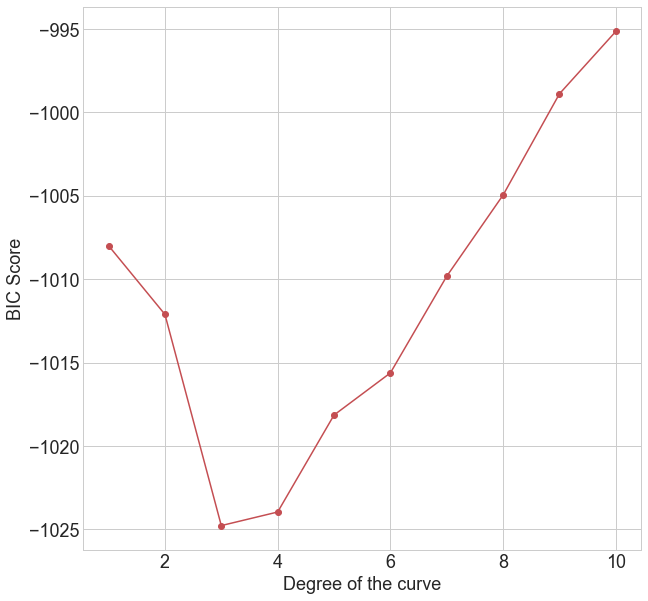

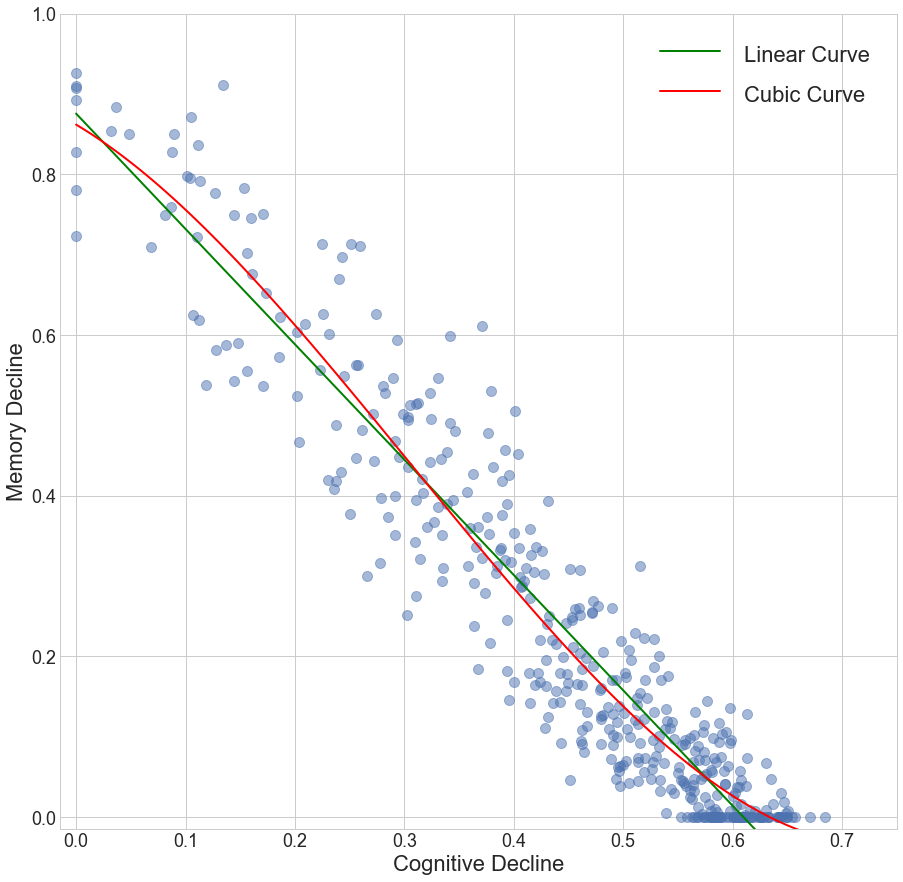

In [45]:
visits = 'm24'
redued_item_24,_ = project_data2(data, visits)
fit_curve(redued_item_24 ,1,3, 'full_data_')

## Education

In [46]:
def fit_curve_2(redued_item_24, order1 , order2, string):
    mpl.style.use('seaborn-whitegrid')
    result_more = redued_item_24.iloc[-200:,:]
    result_less = redued_item_24.iloc[0:200,:]
    x_m = np.asarray(result_more['NMF_2_1'],dtype=float).reshape(-1, 1)
    y_m = np.asarray( result_more['NMF_2_2'] , dtype=float).reshape(-1, 1)
    x_l = np.asarray(result_less['NMF_2_1'],dtype=float).reshape(-1, 1)
    y_l = np.asarray( result_less['NMF_2_2'] , dtype=float).reshape(-1, 1)    
    data_m = pd.DataFrame(x_m,columns=['x'])
    data_m['y'] = y_m
    data_l = pd.DataFrame(x_l,columns=['x'])
    data_l['y'] = y_l    

    # linear model
    poly_reg = PolynomialFeatures(degree = order1, include_bias= False )
    X_poly = poly_reg.fit_transform(x_m)
    model = sm.ols(formula = 'y ~ X_poly', data = data_m).fit()
    model.conf_int()
    model.pvalues
    print('Results for order{}'.format(order1))
    print('BIC for order {} is {} \n'.format( order1,model.bic) )
    print(model.params)
    print('\n')
    a = model.params
    
    # cubic model
    poly_reg = PolynomialFeatures(degree = order1, include_bias= False )
    X_poly = poly_reg.fit_transform(x_l)
    model = sm.ols(formula = 'y ~ X_poly', data = data_l).fit()
    model.conf_int()
    model.pvalues
    print('Results for order{}'.format(order2))
    print('BIC for order {} is {} \n'.format( order2,model.bic) )
    print(model.params)
    print('\n')
    a3 = model.params
    x_new = np.linspace(min(x_l), max(x_m), 100)
    y_new = 0
    y_new3 = 0
    for i in range(order1+1):
        y_new += a[i]*(x_new**i)
    for j in range(order1+1):
        y_new3 += a3[j]*(x_new**j)
    fig3,ax3 = plt.subplots(figsize=(15, 15))
    ax3.scatter(x_m,y_m, s= 80, alpha = 0.5, c = 'g')
    ax3.scatter(x_l,y_l, s= 80, alpha = 0.5 , c = 'r')
    ax3.plot(x_new, y_new, linewidth = 2.0, color= 'green', label = 'Most Educated')
    ax3.plot(x_new, y_new3, linewidth = 2.0, color= 'red',label = 'Least Educated')
    ax3.set_xlim([-0.05, 1.0])
    ax3.set_ylim([-0.015, 1.0])
    ax3.tick_params(labelsize=18)
    ax3.set_xlabel("Cognitive Decline",fontsize=24)
    ax3.set_ylabel("Memory Decline",fontsize=24)
    ax3.legend()
    ax3.grid(True)
    plt.setp(ax3.get_legend().get_texts(), fontsize='24')
    plt.savefig(address + '\\paper_fig\\' + 'Education_difference_Curve_fitting.png',dpi = 200)

(435, 290)
Results for order1
BIC for order 1 is -482.8315646798172 

Intercept    0.913336
X_poly      -1.484517
dtype: float64


Results for order3
BIC for order 3 is -448.04696762932537 

Intercept    0.859527
X_poly      -1.422228
dtype: float64




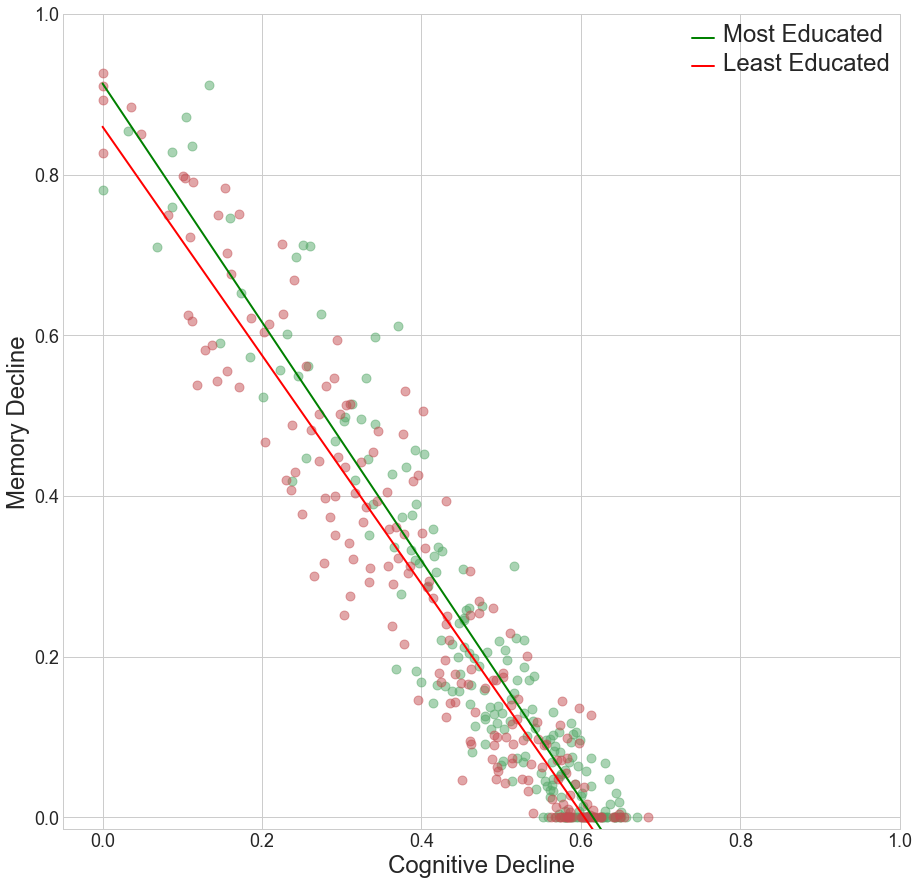

In [47]:
# Full data
redued_item_24, _ = project_data2(data, visits)
cols['adni_merge'] = ['RID', 'VISCODE','COLPROT','AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY']
adni_merge = pd.read_csv('ADNI\\Raw_Data\\Demographic_Plots\\ADNIMERGE.csv', usecols=cols['adni_merge'], index_col = ['RID'])
adni_merge = adni_merge.groupby(adni_merge.index).min()
adni_merge_chosen = adni_merge[adni_merge.index.isin(redued_item_24.index)] 
result = pd.concat([adni_merge_chosen, redued_item_24] , axis = 1, ignore_index= False)
slope_edu_less = []
slope_edu_greater = []
result = result.sort_values(by=['PTEDUCAT'])
fit_curve_2(result,1,3,'Education_difference_')

In [48]:
result.shape

(435, 23)

In [49]:
result.head()

,VISCODE,COLPROT,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,PCA_1,PCA_2,...,ICA_1,ICA_2,NMF_2_1,NMF_2_2,NMF_3_1,NMF_3_2,NMF_3_3,ICA_3_1,ICA_3_2,ICA_3_3
RID,,,,,,,,,,,,,,,,,,,,,
4073,bl,ADNI2,76.2,Male,11,Not Hisp/Latino,White,Married,1.60331,0.180903,...,0.0387191,0.0185434,0.29513,0.448764,0.329304,0.331188,0.132556,-0.00749572,-0.0514399,0.022923
4476,bl,ADNI2,88.6,Male,11,Not Hisp/Latino,Asian,Married,1.86121,0.554018,...,0.0570449,0.00667283,0.271088,0.501506,0.267392,0.390062,0.188672,-0.0642057,-0.0158985,-0.0111968
4494,bl,ADNI2,71.1,Male,12,Not Hisp/Latino,White,Married,4.40472,0.364532,...,0.101714,0.0566628,0.0486881,0.849921,0.256234,0.651103,0,-0.113048,-0.0389797,0.0288149
4299,bl,ADNI2,76.8,Female,12,Not Hisp/Latino,White,Married,1.67938,1.84408,...,0.0987416,-0.0520165,0.305164,0.513262,0.152528,0.446397,0.37447,0.0273642,-0.159605,-0.0284989
4873,bl,ADNI2,82.6,Male,12,Not Hisp/Latino,White,Married,1.08141,-1.82028,...,-0.0421875,0.0963689,0.302419,0.252071,0.40718,0.135459,0,-0.00692419,0.0480759,0.0939943


In [50]:
result[['VISCODE','PTRACCAT']].groupby('PTRACCAT')['VISCODE'].count() /result.shape[0]

PTRACCAT
Am Indian/Alaskan    0.002299
Asian                0.016092
Black                0.034483
Hawaiian/Other PI    0.002299
More than one        0.011494
White                0.933333
Name: VISCODE, dtype: float64

In [51]:
result[['VISCODE','PTGENDER']].groupby('PTGENDER')['VISCODE'].count() /result.shape[0]

PTGENDER
Female    0.462069
Male      0.537931
Name: VISCODE, dtype: float64

## Ploted features in 2 dimensions using Progression Indicator Vectors

In [52]:
visits = 'm24'
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis, M_H_T2, M_H_T3 = project_data(data, visits)
M_H_T2.to_csv(address + 'all_2d_list_ppr.csv')

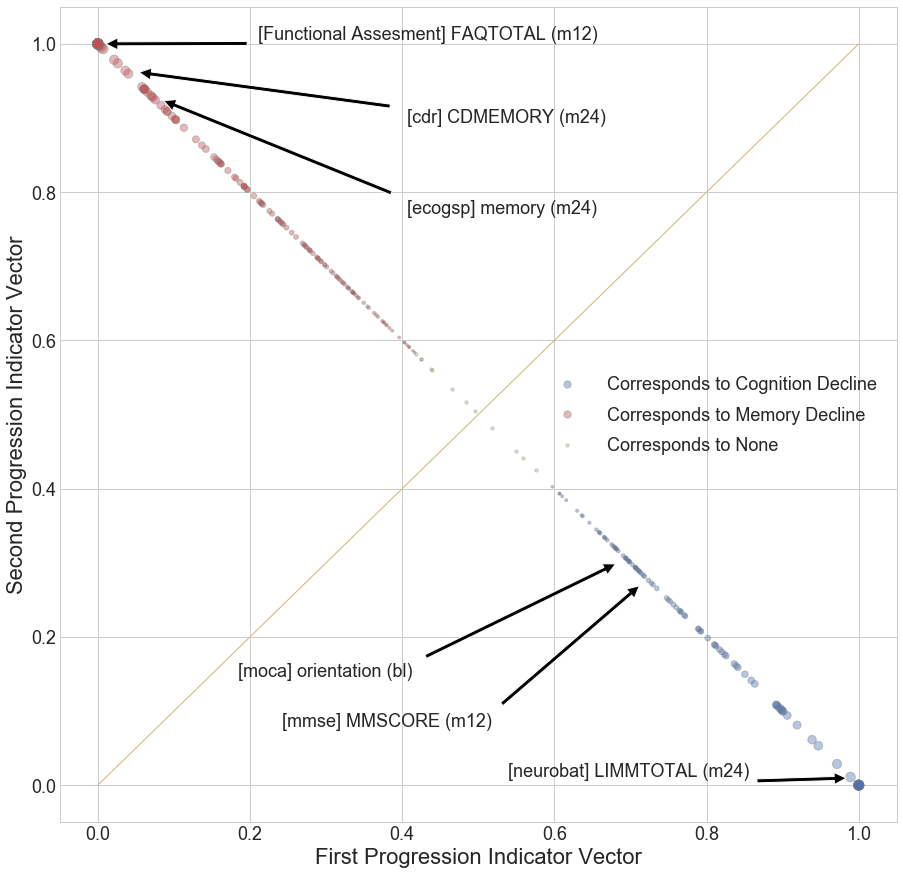

In [61]:

mpl.style.use('seaborn-whitegrid')
M_H_T2_axis1 = M_H_T2[ M_H_T2['new'] == 'axis 1' ]
M_H_T2_axis2 = M_H_T2[ M_H_T2['new'] == 'axis 2' ]
M_H_T2_amb = M_H_T2[ M_H_T2['new'] == 'ambigious' ]
x_new = np.linspace(0, 1, 100)
y_new = x_new
fig3,ax3 = plt.subplots(figsize=(15, 15))
ax3.scatter(M_H_T2_axis1["axis 1"], M_H_T2_axis1["axis 2"],alpha = 0.4, s= (M_H_T2_axis1['axis 1']**5)*100,linewidth=1.0, cmap="Blues",color= 'b', edgecolors="grey",label='Corresponds to Cognition Decline')
ax3.scatter(M_H_T2_axis2["axis 1"], M_H_T2_axis2["axis 2"],alpha = 0.4, s= (M_H_T2_axis2['axis 2']**5)*100,linewidth=1.0,cmap="Oranges",color= 'r', edgecolors="grey",label='Corresponds to Memory Decline')
ax3.scatter(M_H_T2_amb["axis 1"], M_H_T2_amb["axis 2"],alpha = 0.4,s=10,linewidth=1.0,  edgecolors="grey",color= 'y',label='Corresponds to None')
ax3.plot(x_new, y_new, alpha = 1.0, linewidth = 1.0, color= 'y')
ax3.set_xlim([-0.05, 1.05])
ax3.set_ylim([-0.05, 1.05])
ax3.set_ylabel('Second Progression Indicator Vector',fontsize=22)
ax3.set_xlabel('First Progression Indicator Vector',fontsize=22)

ax3.annotate('[Functional Assesment] FAQTOTAL (m12)', xy=(0.0, 1.0), xytext=(0.0+0.21, 1.006),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=18)
ax3.annotate('[cdr] CDMEMORY (m24)', xy=(0.0358,  0.9641 ), xytext=(0.355936585-0.1 + 0.15 , 0.644063415+ 0.25),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=18)
ax3.annotate('[ecogsp] memory (m24)', xy=(0.06960, 0.930394 ), xytext=( 0.355936585-0.1 + 0.15 , 0.621609925+ 0.15),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=18)
#ax3.annotate('[cdr] CDMEMORY (m12)', xy=(0.09121,  0.90878 ), xytext=(0.355936585-0.1 + 0.15 , 0.644063415+ 0.035),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=18)



ax3.annotate('[moca] orientation (bl)', xy=( 0.694550084 , 0.30544), xytext=(0.634160998-0.45, 0.365839002-0.22),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=18)
#ax3.annotate('[moca] moca abstraction (m06)', xy=(0.665256847, 0.334743153), xytext=(0.665256847-0.45, 0.334743153-0.2),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=18)
ax3.annotate('[mmse] MMSCORE (m12)', xy=(0.722057 , 0.27794), xytext=(0.69147672-0.45, 0.30852328-0.23),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=18)
ax3.annotate('[neurobat] LIMMTOTAL (m24)', xy=(0.99031, 0.0096815), xytext=(0.9891-0.45, 0.01086),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=18)


ax3 = plt.gca()
# ax3.set_axis_bgcolor((0.898, 0.898, 0.898))
fig3 = plt.gcf()
ax3.tick_params(labelsize=22)
ax3.legend(fontsize = 22)
ax3.grid(True)
plt.setp(ax3.get_legend().get_texts(), fontsize='18')
plt.setp(ax3.get_xticklabels(), fontsize=18)
plt.setp(ax3.get_yticklabels(), fontsize=18)
plt.savefig(address + '\\paper_fig\\'+'xyplot.png',dpi = 200)


## APOE4 in original class

In [54]:
redued = redued_item_24
cols['apoe4'] = ['RID' , 'VISCODE' , 'APOE4'   ]
apoe4 = pd.read_csv("C:\\Users\\Vipul Satone\\health data\\ADNI\\Raw_Data\\Assessment\\apoe4\\ADNIMERGE.csv",index_col='RID', usecols=cols['apoe4'])

apoe4['VISCODE2'] = apoe4['VISCODE']
apoe4['VISCODE'].value_counts()
del apoe4['VISCODE']
apoe4 = apoe4[apoe4['VISCODE2'].isin(['m24']) ]  

redued = redued.merge(apoe4['APOE4'].to_frame(), left_index=True, right_index=True)

print( redued['APOE4'].value_counts(normalize=True) )

print( redued['DXCHANGE'].value_counts(normalize=True) )

print( redued[ redued['DXCHANGE'] == 1 ]['APOE4'].value_counts(normalize=True) )

print( redued[ redued['DXCHANGE'] == 2 ]['APOE4'].value_counts(normalize=True) )

print( redued[ redued['DXCHANGE'] == 3 ]['APOE4'].value_counts(normalize=True) )


0.0    0.573770
1.0    0.339578
2.0    0.086651
Name: APOE4, dtype: float64
2    0.437939
1    0.379391
3    0.182670
Name: DXCHANGE, dtype: float64
0.0    0.722222
1.0    0.259259
2.0    0.018519
Name: APOE4, dtype: float64
0.0    0.566845
1.0    0.326203
2.0    0.106952
Name: APOE4, dtype: float64
1.0    0.538462
0.0    0.282051
2.0    0.179487
Name: APOE4, dtype: float64


### Descriptine stats of the data

In [55]:
d1 = pd.DataFrame( redued['DXCHANGE'].replace([1,2,3],['Control','MCI','Dementia']) )
d1.index = d1.index.astype(int)
dis_data = pd.merge(result[['VISCODE','COLPROT','AGE','PTGENDER','PTEDUCAT','PTETHCAT','PTRACCAT','PTMARRY']], d1, on='RID', how='inner')

print( dis_data[['VISCODE','PTGENDER']].groupby('PTGENDER')['VISCODE'].count() / dis_data.shape[0] )
print('\n')
print( dis_data[['VISCODE','PTGENDER']].groupby('PTGENDER')['VISCODE'].count()  )
print('\n')
print('-'*30)

print( dis_data[['VISCODE','PTRACCAT']].groupby('PTRACCAT')['VISCODE'].count() / dis_data.shape[0] )
print('\n')
print( dis_data[['VISCODE','PTRACCAT']].groupby('PTRACCAT')['VISCODE'].count()  )
print('\n')
print('-'*30)

stats = dis_data[['AGE','DXCHANGE']].groupby( ['DXCHANGE'] )['AGE'].agg( ['mean', 'count', 'std'] )


ci95_hi = []
ci95_lo = []

for i in stats.index:
    m, c, s = stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))
    
stats['ci95_hi'] = ci95_hi
stats['ci95_lo'] = ci95_lo

print(stats)
print('-'*30)

print( dis_data[['VISCODE','DXCHANGE']].groupby('DXCHANGE')['VISCODE'].count() / dis_data.shape[0] )
print('\n')
print( dis_data[['VISCODE','DXCHANGE']].groupby('DXCHANGE')['VISCODE'].count()  )
print('\n')
print('-'*30)
print('\n')
print(dis_data.shape)
print('-'*30)


ci95_hi =  np.mean( dis_data['AGE'] ) + 1.96* np.std( dis_data['AGE'] )   /math.sqrt( dis_data.shape[0]  )
ci95_lo =  np.mean( dis_data['AGE'] ) - 1.96* np.std( dis_data['AGE'] )   /math.sqrt( dis_data.shape[0]  )
print(f'Total low and high CI is {ci95_hi} and {ci95_lo}  and mean is {  np.mean( dis_data.AGE)  }')

PTGENDER
Female    0.466042
Male      0.533958
Name: VISCODE, dtype: float64


PTGENDER
Female    199
Male      228
Name: VISCODE, dtype: int64


------------------------------
PTRACCAT
Am Indian/Alaskan    0.002342
Asian                0.014052
Black                0.035129
Hawaiian/Other PI    0.002342
More than one        0.011710
White                0.934426
Name: VISCODE, dtype: float64


PTRACCAT
Am Indian/Alaskan      1
Asian                  6
Black                 15
Hawaiian/Other PI      1
More than one          5
White                399
Name: VISCODE, dtype: int64


------------------------------
               mean  count       std    ci95_hi    ci95_lo
DXCHANGE                                                  
Control   72.946296    162  6.106143  73.886594  72.005998
Dementia  73.215385     78  7.787520  74.943640  71.487129
MCI       71.625134    187  7.364471  72.680679  70.569588
------------------------------
DXCHANGE
Control     0.379391
Dementia    0.182670
MCI  

## APOE 4 Dist

2    114
0     98
1     53
Name: 0, dtype: int64


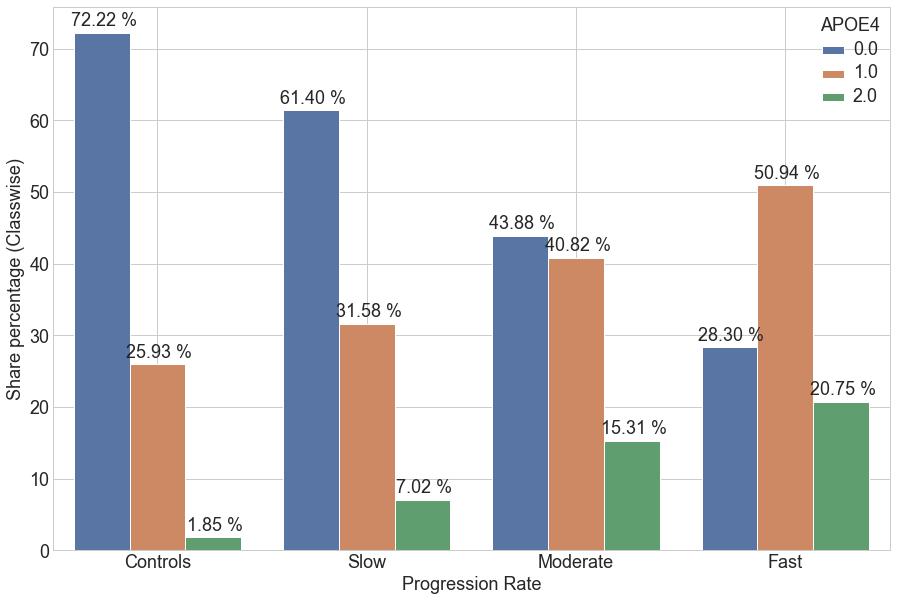

In [56]:
visits = 'm24'
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis, M_H_T2, M_H_T3 = project_data(data, visits)
M_mci_dem = redued_item_24
M_mci_dem_nmf_all = M_mci_dem[['NMF_2_1','NMF_2_2','NMF_3_1', 'NMF_3_2','NMF_3_3']].copy()
M_mci_dem_nmf = M_mci_dem[['NMF_2_1', 'NMF_2_2']]
M_mci_dem_nmf_proj_all = M_mci_dem_nmf_all[~(redued_item_24.DXCHANGE.isin([1]) )] # removing controls
M_mci_dem_nmf_proj_3d_only = M_mci_dem_nmf_proj_all[['NMF_3_1','NMF_3_2','NMF_3_3']]
M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_all[['NMF_2_1','NMF_2_2']]

try:
    colors_categories_item_24_no_controls = redued_item_24[~(redued_item_24.DXCHANGE.isin([1]) )]['DXCHANGE'].replace([1,2,3], ['red', 'blue', 'green'])
except:
    pass

# Function to organize color sequence as per high low and medium
def organize_prediction_moca(M_mci_dem_nmf_proj_3d_only,Predict_gmm):
    M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_3d_only
    M_mci_dem_nmf_proj['predicted'] = Predict_gmm
    a = list(pd.unique(Predict_gmm.iloc[:,0]))
    srt = np.empty((len(a),2))
    for i in a:
        a = M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #b =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #c =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,0].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        srt[i,1] = a
        srt[i,0] = i
    srt = pd.DataFrame(srt).sort_values([1])
    Predict_gmm.replace([srt.iloc[0,0],srt.iloc[1,0], srt.iloc[2,0] ],[0,1,2], inplace=True)   
    return pd.DataFrame(Predict_gmm)

model_gmm = mixture.GaussianMixture(n_components=3, covariance_type='diag',  random_state = 0)
model_gmm.fit(M_mci_dem_nmf_proj) # print(gmm.means_)
# label the predicted and only keep HC and PDs
Predict_gmm = pd.DataFrame(model_gmm.predict(M_mci_dem_nmf_proj))
print(Predict_gmm.iloc[:,0].value_counts())
Predict_gmm.columns = ['predicted']
Predict_gmm.index = M_mci_dem_nmf_proj.index
Predict_gmm = organize_prediction_moca(M_mci_dem_nmf_proj,Predict_gmm)
M_mci_dem_nmf_proj['predicted'] = Predict_gmm
#plot_side_by_side_2d(M_mci_dem_nmf_proj,Predict_gmm,redued_item_24,colors_categories_item_24,'item24','gmm')    
nl_data = M_mci_dem_nmf[(redued_item_24.DXCHANGE.isin([1]) )]
data_prediction_labels = pd.concat([nl_data,M_mci_dem_nmf_proj]).fillna(3)

cols['apoe4'] = ['RID' , 'VISCODE' , 'APOE4'   ]
apoe4 = pd.read_csv("C:\\Users\\Vipul Satone\\health data\\ADNI\\Raw_Data\\Assessment\\apoe4\\ADNIMERGE.csv",index_col='RID', usecols=cols['apoe4'])
apoe4['VISCODE2'] = apoe4['VISCODE']
apoe4['VISCODE'].value_counts()
del apoe4['VISCODE']
apoe4 = apoe4[apoe4['VISCODE2'].isin(['m24']) ] 
Predict_gmm = data_prediction_labels
redued = Predict_gmm.merge(apoe4['APOE4'].to_frame(), left_index=True, right_index=True)
redued = redued.merge(redued_item_24['DXCHANGE'].to_frame(), left_index=True, right_index=True)

redued['predicted'] = redued['predicted'].replace([0,1,2,3],['Slow','Moderate','Fast','Controls'])
redued['DXCHANGE'] = redued['DXCHANGE'].replace([1,2,3],['Control','MCI','Dementia'])

mpl.style.use('seaborn-whitegrid')
redued = redued.rename(columns = {'predicted':'Progression Rate'})
plt.figure(figsize=(15, 10)) 
a = redued.groupby(['Progression Rate'])['APOE4'].value_counts(normalize=True).rename('Share percentage (Classwise)').mul(100).reset_index().sort_values('Progression Rate')
axis = sns.barplot(x="Progression Rate", y="Share percentage (Classwise)", hue="APOE4", order = ['Controls','Slow','Moderate','Fast'] ,data=a)
axis.tick_params(labelsize=18)
axis.set_xlabel("Progression Rate",fontsize=18)
axis.set_ylabel("Share percentage (Classwise)",fontsize=18)
axis.grid(True)
plt.setp(axis.get_legend().get_texts(), fontsize='18') # for legend text
plt.setp(axis.get_legend().get_title(), fontsize='18') # for legend title
for p in axis.patches:
    axis.annotate("%.2f" % p.get_height() + ' %', (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', rotation=0, xytext=(2, 12), textcoords='offset points',size=18)
# plt.setp(ax.get_xticklabels(), fontsize=18)    
plt.savefig(address + '\\paper_fig\\'+ 'APOE4_dist_barplot_24.png',dpi = 200)

In [57]:
data.columns = [ str(a) + '__' + str(b) for a, b in zip( data.T.reset_index()['features'] , data.T.reset_index()['visits'] )]
adas = pd.read_csv('ADNI\\Raw_Data\\Assessment\\ADAS_ADNIGO23.csv')
adas = adas[ ['RID','VISCODE2','TOTAL13','TOTSCORE'] ]
adas.head()

adas = adas[adas['VISCODE2'].isin(['bl','m12','m06']) ]  
adas.shape

adas = adas.set_index(['RID','VISCODE2'])
adas = adas.unstack()
adas.shape

adas[ adas.isnull().sum(axis = 1) >0 ]
adas_rid_list = adas[ adas.isnull().sum(axis = 1) >0 ].index

new_col_list_adas = adas.columns.levels[0]
for a in new_col_list_adas: 
    adas[a] = adas[a].interpolate(method='linear', axis=1, limit=2, limit_direction='both')
    
adas.isnull().sum().sum()
adas.head()

adas_col_list = [ 'adas' + '__' + i + '__' + z for i, z in zip(  adas.columns.get_level_values(0), adas.columns.get_level_values(1) ) ]
adas.columns = adas_col_list

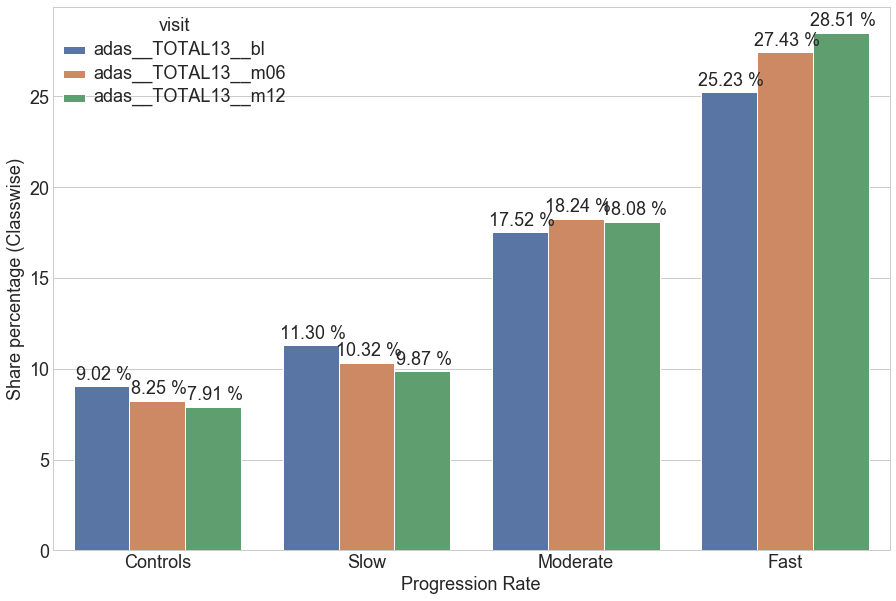

In [58]:
Predict_gmm.columns = ['NMF_2_1', 'NMF_2_2', 'Progression Rate']
Predict_gmm['Progression Rate'] = Predict_gmm['Progression Rate'].replace([0.0 ,1.0,2.0,3.0], ['Slow','Moderate','Fast','Controls']  )

adas_stack = adas[['adas__TOTAL13__bl','adas__TOTAL13__m06','adas__TOTAL13__m12']].stack()
adas_stack = adas_stack.astype(float)
adas_data = pd.DataFrame(adas_stack).join(Predict_gmm, how = 'inner')




adas_data1 = adas_data.reset_index().groupby(['Progression Rate','level_1'])[0].mean().rename('avg adas').reset_index()
adas_data1.columns = ['Progression Rate', 'visit', 'avg adas score']



plt.figure(figsize=(15, 10)) 
axis = sns.barplot(x="Progression Rate", y="avg adas score", hue="visit", hue_order = ['adas__TOTAL13__bl','adas__TOTAL13__m06','adas__TOTAL13__m12']  , order = ['Controls','Slow','Moderate','Fast'] ,data=adas_data1)
axis.tick_params(labelsize=18)
axis.set_xlabel("Progression Rate",fontsize=18)
axis.set_ylabel("Share percentage (Classwise)",fontsize=18)
plt.setp(axis.get_legend().get_texts(), fontsize='18') # for legend text
plt.setp(axis.get_legend().get_title(), fontsize='18') # for legend title
for p in axis.patches:
    axis.annotate("%.2f" % p.get_height() + ' %', (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', rotation=0, xytext=(2, 12), textcoords='offset points',size=18)
plt.setp(axis.get_xticklabels(), fontsize=18)    
plt.savefig(address + '\\paper_fig\\'+ 'adas_total13_48.png',dpi = 200)   

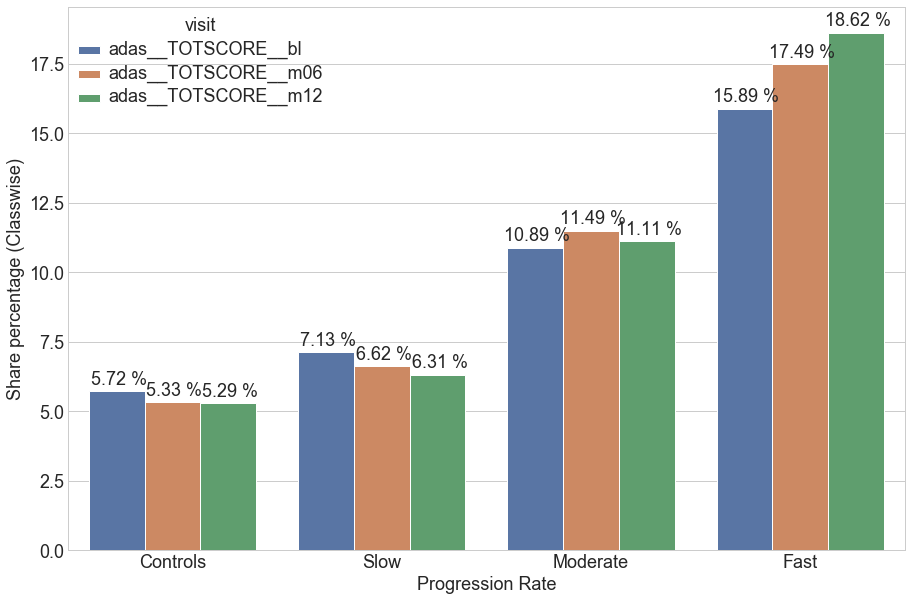

In [59]:
Predict_gmm.columns = ['NMF_2_1', 'NMF_2_2', 'Progression Rate']
Predict_gmm['Progression Rate'] = Predict_gmm['Progression Rate'].replace([0.0 ,1.0,2.0,3.0], ['Slow','Moderate','Fast','Controls']  )

adas_stack = adas[['adas__TOTSCORE__bl','adas__TOTSCORE__m06','adas__TOTSCORE__m12']].stack()
adas_stack = adas_stack.astype(float)
adas_data = pd.DataFrame(adas_stack).join(Predict_gmm, how = 'inner')

# Creating and saving the graph

adas_data1 = adas_data.reset_index().groupby(['Progression Rate','level_1'])[0].mean().rename('avg adas').reset_index()
adas_data1.columns = ['Progression Rate', 'visit', 'avg adas score']
plt.figure(figsize=(15, 10)) 
axis = sns.barplot(x="Progression Rate", y="avg adas score", hue="visit", hue_order = ['adas__TOTSCORE__bl','adas__TOTSCORE__m06','adas__TOTSCORE__m12']  , order = ['Controls','Slow','Moderate','Fast'] ,data=adas_data1)
axis.tick_params(labelsize=18)
axis.set_xlabel("Progression Rate",fontsize=18)
axis.set_ylabel("Share percentage (Classwise)",fontsize=18)
plt.setp(axis.get_legend().get_texts(), fontsize='18') # for legend text
plt.setp(axis.get_legend().get_title(), fontsize='18') # for legend title
for p in axis.patches:
    axis.annotate("%.2f" % p.get_height() + ' %', (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', rotation=0, xytext=(2, 12), textcoords='offset points',size=18)
plt.setp(axis.get_xticklabels(), fontsize=18)    
plt.savefig(address + '\\paper_fig\\'+ 'adas_TOTSCORE_48.png',dpi = 200)  

## Odds Ratio

In [28]:
print( redued['APOE4'].value_counts(normalize=True) )

print( redued['Progression Rate'].value_counts(normalize=True) )

print( redued[ redued['Progression Rate'] == 'Controls' ]['APOE4'].value_counts() )

print( redued[ redued['Progression Rate'] == 'Low' ]['APOE4'].value_counts(normalize=True) )

print( redued[ redued['Progression Rate'] == 'Medium' ]['APOE4'].value_counts(normalize=True) )

print( redued[ redued['Progression Rate'] == 'High' ]['APOE4'].value_counts(normalize=True) )


0.0    0.573770
1.0    0.339578
2.0    0.086651
Name: APOE4, dtype: float64
Controls    0.379391
Slow        0.266979
Moderate    0.229508
Fast        0.124122
Name: Progression Rate, dtype: float64
0.0    117
1.0     42
2.0      3
Name: APOE4, dtype: int64
Series([], Name: APOE4, dtype: float64)
Series([], Name: APOE4, dtype: float64)
Series([], Name: APOE4, dtype: float64)


2    114
0     98
1     53
Name: 0, dtype: int64
Slow        114
Moderate     68
Fast          5
Name: Progression Rate, dtype: int64
Fast        48
Moderate    30
Name: Progression Rate, dtype: int64


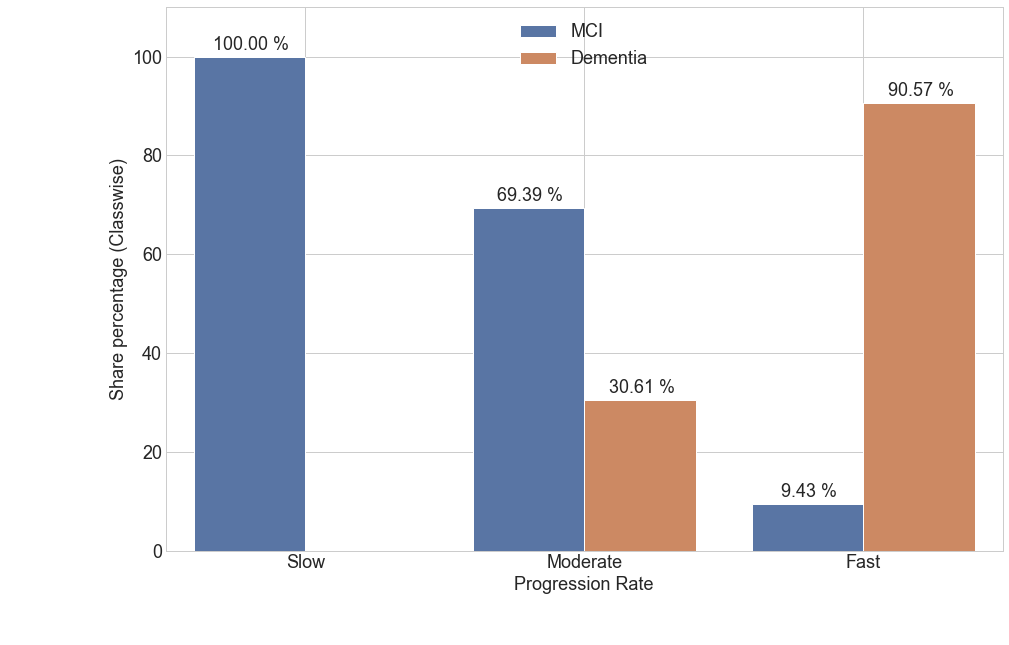

In [29]:
visits = 'm24'
%matplotlib inline
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis, M_H_T2, M_H_T3 = project_data(data, visits)
    
M_mci_dem = redued_item_24
M_mci_dem_nmf_all = M_mci_dem[['NMF_2_1','NMF_2_2','NMF_3_1', 'NMF_3_2','NMF_3_3']].copy()
M_mci_dem_nmf = M_mci_dem[['NMF_2_1', 'NMF_2_2']]
M_mci_dem_nmf_proj_all = M_mci_dem_nmf_all[~(redued_item_24.DXCHANGE.isin([1]) )] # removing controls
M_mci_dem_nmf_proj_3d_only = M_mci_dem_nmf_proj_all[['NMF_3_1','NMF_3_2','NMF_3_3']]
M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_all[['NMF_2_1','NMF_2_2']]

try:
    colors_categories_item_24_no_controls = redued_item_24[~(redued_item_24.DXCHANGE.isin([1]) )]['DXCHANGE'].replace([1,2,3], ['red', 'blue', 'green'])
except:
    pass

def organize_prediction_moca(M_mci_dem_nmf_proj_3d_only,Predict_gmm):
    mpl.style.use('seaborn-whitegrid')
    M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_3d_only
    M_mci_dem_nmf_proj['predicted'] = Predict_gmm
    a = list(pd.unique(Predict_gmm.iloc[:,0]))
    srt = np.empty((len(a),2))
    for i in a:
        a = M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #b =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #c =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,0].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        srt[i,1] = a
        srt[i,0] = i
    srt = pd.DataFrame(srt).sort_values([1])
    Predict_gmm.replace([srt.iloc[0,0],srt.iloc[1,0], srt.iloc[2,0] ],[0,1,2], inplace=True)   
    return pd.DataFrame(Predict_gmm)

model_gmm = mixture.GaussianMixture(n_components=3, covariance_type='diag',  random_state = 0)
model_gmm.fit(M_mci_dem_nmf_proj) # print(gmm.means_)
# label the predicted and only keep HC and PDs
Predict_gmm = pd.DataFrame(model_gmm.predict(M_mci_dem_nmf_proj))
print(Predict_gmm.iloc[:,0].value_counts())
Predict_gmm.columns = ['predicted']
Predict_gmm.index = M_mci_dem_nmf_proj.index
Predict_gmm = organize_prediction_moca(M_mci_dem_nmf_proj,Predict_gmm)
M_mci_dem_nmf_proj['predicted'] = Predict_gmm

nl_data = M_mci_dem_nmf[(redued_item_24.DXCHANGE.isin([1]) )]
data_prediction_labels = pd.concat([nl_data,M_mci_dem_nmf_proj]).fillna(3)

cols['apoe4'] = ['RID' , 'VISCODE' , 'APOE4'   ]
apoe4 = pd.read_csv("C:\\Users\\Vipul Satone\\health data\\ADNI\\Raw_Data\\Assessment\\apoe4\\ADNIMERGE.csv",index_col='RID', usecols=cols['apoe4'])
apoe4['VISCODE2'] = apoe4['VISCODE']
apoe4['VISCODE'].value_counts()
del apoe4['VISCODE']
apoe4 = apoe4[apoe4['VISCODE2'].isin(['m24']) ] 
Predict_gmm = data_prediction_labels
redued = Predict_gmm.merge(apoe4['APOE4'].to_frame(), left_index=True, right_index=True)
redued = redued.merge(redued_item_24['DXCHANGE'].to_frame(), left_index=True, right_index=True)
redued['predicted'] = redued['predicted'].replace([0,1,2,3],['Slow','Moderate','Fast','Controls'])
redued['DXCHANGE'] = redued['DXCHANGE'].replace([1,2,3],['Controls','MCI','Dementia'])
redued = redued.rename(columns = {'predicted':'Progression Rate'})

plt.figure(figsize=(15, 10)) 
a = redued.groupby(['Progression Rate'])['DXCHANGE'].value_counts(normalize=True).rename('percentage (Classwise)').mul(100).reset_index().sort_values('DXCHANGE')
axis = sns.barplot(x="Progression Rate", y="percentage (Classwise)", hue="DXCHANGE", hue_order = ['MCI','Dementia']  , order = ['Slow','Moderate','Fast'] ,data=a)
axis.tick_params(labelsize=18)
axis.set_xlabel("Progression Rate",fontsize=18)
axis.set_ylabel("Share percentage (Classwise)",fontsize=18)
axis.set_ylim( ([0,110]) )
axis.legend( fontsize = 18,loc='upper center')
axis.grid(True)
plt.setp(axis.get_legend().get_texts(), fontsize='18') # for legend text
plt.setp(axis.get_legend().get_title(), fontsize='18') # for legend title
for p in axis.patches:
    axis.annotate("%.2f" % p.get_height() + ' %', (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', rotation=0, xytext=(2, 12), textcoords='offset points',size=18)
plt.setp(axis.get_xticklabels(), fontsize=18)
plt.savefig(address + '\\paper_fig\\' + 'oddsratio_dist_barplot_24.png',dpi = 200)

a = redued.groupby(['Progression Rate'])['DXCHANGE'].value_counts().rename('Count').reset_index().sort_values('Progression Rate')

print( redued[ redued['DXCHANGE'] == 'MCI' ]['Progression Rate'].value_counts() )
print( redued[ redued['DXCHANGE'] == 'Dementia' ]['Progression Rate'].value_counts() )

## MMSE and GD Scale and FAQ

(435, 290)
2    114
0     98
1     53
Name: 0, dtype: int64


<Figure size 1080x720 with 0 Axes>

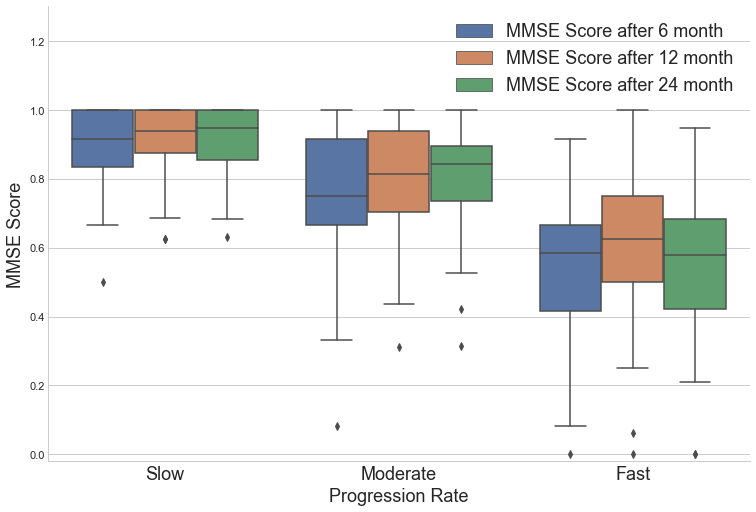

<Figure size 1080x720 with 0 Axes>

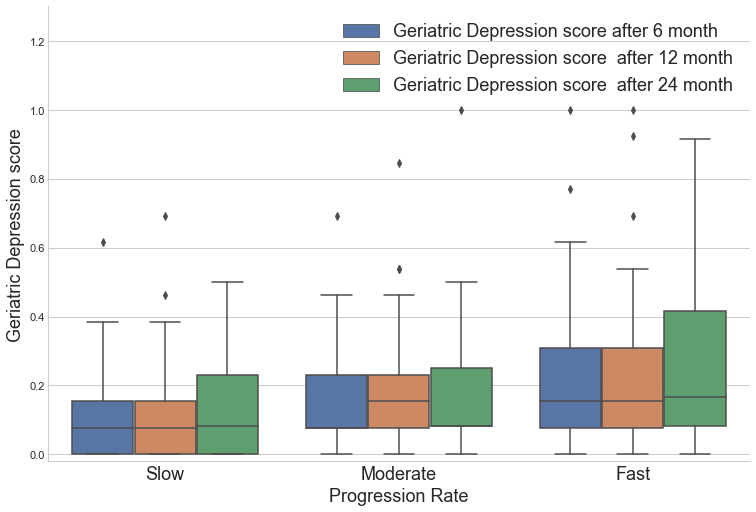

<Figure size 1080x720 with 0 Axes>

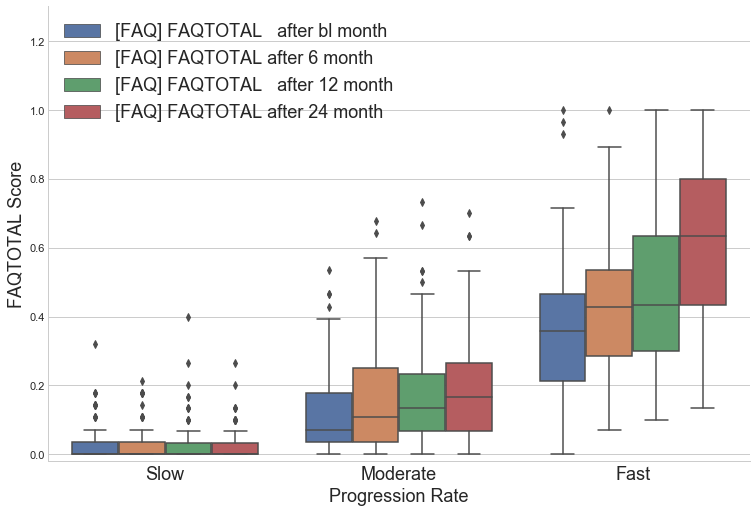

In [31]:
visits = 'm24'
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis, M_H_T2, M_H_T3 = project_data(data, visits)
_, M_chosen = project_data2(data, visits)
    
M_mci_dem = redued_item_24
M_mci_dem_nmf_all = M_mci_dem[['NMF_2_1','NMF_2_2','NMF_3_1', 'NMF_3_2','NMF_3_3']].copy()
M_mci_dem_nmf = M_mci_dem[['NMF_2_1', 'NMF_2_2']]
M_mci_dem_nmf_proj_all = M_mci_dem_nmf_all[~(redued_item_24.DXCHANGE.isin([1]) )] # removing controls
M_mci_dem_nmf_proj_3d_only = M_mci_dem_nmf_proj_all[['NMF_3_1','NMF_3_2','NMF_3_3']]
M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_all[['NMF_2_1','NMF_2_2']]

try:
    colors_categories_item_24_no_controls = redued_item_24[~(redued_item_24.DXCHANGE.isin([1]) )]['DXCHANGE'].replace([1,2,3], ['red', 'blue', 'green'])
except:
    pass

def organize_prediction_moca(M_mci_dem_nmf_proj_3d_only,Predict_gmm):
    mpl.style.use('seaborn-whitegrid')
    M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_3d_only
    M_mci_dem_nmf_proj['predicted'] = Predict_gmm
    a = list(pd.unique(Predict_gmm.iloc[:,0]))
    srt = np.empty((len(a),2))
    for i in a:
        a = M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #b =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #c =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,0].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        srt[i,1] = a
        srt[i,0] = i
    srt = pd.DataFrame(srt).sort_values([1])
    Predict_gmm.replace([srt.iloc[0,0],srt.iloc[1,0], srt.iloc[2,0] ],[0,1,2], inplace=True)   
    return pd.DataFrame(Predict_gmm)

model_gmm = mixture.GaussianMixture(n_components=3, covariance_type='diag',  random_state = 0)
model_gmm.fit(M_mci_dem_nmf_proj) # print(gmm.means_)
# label the predicted and only keep HC and PDs
Predict_gmm = pd.DataFrame(model_gmm.predict(M_mci_dem_nmf_proj))
print(Predict_gmm.iloc[:,0].value_counts())
Predict_gmm.columns = ['predicted']
Predict_gmm.index = M_mci_dem_nmf_proj.index
Predict_gmm = organize_prediction_moca(M_mci_dem_nmf_proj,Predict_gmm)
M_mci_dem_nmf_proj['predicted'] = Predict_gmm
#plot_side_by_side_2d(M_mci_dem_nmf_proj,Predict_gmm,redued_item_24,colors_categories_item_24,'item24','gmm')    
nl_data = M_mci_dem_nmf[(redued_item_24.DXCHANGE.isin([1]) )]
data_prediction_labels = pd.concat([nl_data,M_mci_dem_nmf_proj]).fillna(3)

cols['apoe4'] = ['RID' , 'VISCODE' , 'APOE4'   ]
apoe4 = pd.read_csv("C:\\Users\\Vipul Satone\\health data\\ADNI\\Raw_Data\\Assessment\\apoe4\\ADNIMERGE.csv",index_col='RID', usecols=cols['apoe4'])
apoe4['VISCODE2'] = apoe4['VISCODE']
apoe4['VISCODE'].value_counts()
del apoe4['VISCODE']
apoe4 = apoe4[apoe4['VISCODE2'].isin(['m24']) ] 
Predict_gmm = data_prediction_labels
redued = Predict_gmm.merge(apoe4['APOE4'].to_frame(), left_index=True, right_index=True)
redued = redued.merge(redued_item_24['DXCHANGE'].to_frame(), left_index=True, right_index=True)


redued = redued.merge(M_chosen[[ 'gd_scale__GDTOTAL__m24',  'FAQ__FAQTOTAL__m24','FAQ__FAQTOTAL__m06','FAQ__FAQTOTAL__bl','FAQ__FAQTOTAL__m12', 'mmse__MMSCORE__m06','mmse__MMSCORE__m12','mmse__MMSCORE__m24','gd_scale__GDTOTAL__m06','gd_scale__GDTOTAL__m12']], left_index=True, right_index=True)

redued['predicted'] = redued['predicted'].replace([0,1,2,3],['Slow','Moderate','Fast','Controls'])
redued['DXCHANGE'] = redued['DXCHANGE'].replace([1,2,3],['Controls','MCI','Dementia'])



redued_2 = redued[['mmse__MMSCORE__m06','predicted']]
redued_2['Progression Vector'] = 'MMSE Score after 6 month'
redued_2.columns = ['val','predicted','Progression Vector']

redued_1 = redued[['mmse__MMSCORE__m12','predicted']]
redued_1['Progression Vector'] = 'MMSE Score after 12 month'
redued_1.columns = ['val','predicted','Progression Vector']

redued_3 = redued[['mmse__MMSCORE__m24','predicted']]
redued_3['Progression Vector'] = 'MMSE Score after 24 month'
redued_3.columns = ['val','predicted','Progression Vector']
redued_new = pd.concat([redued_1,redued_2,redued_3])

redued_new = redued_new.loc[  redued_new.predicted != 'Controls' ,:  ]
redued_new['val'] = redued_new['val'].astype(float)

plt.figure(figsize=(15, 10)) 
axis = sns.factorplot("predicted", hue="Progression Vector", y="val", hue_order = ['MMSE Score after 6 month','MMSE Score after 12 month','MMSE Score after 24 month' ],  order =  ['Slow','Moderate','Fast'],data=redued_new,size =7, aspect = 1.5, kind="box",legend_out=False)
for ax in axis.axes.flat:
    ax.set_xlabel("Progression Rate",fontsize=18)
    ax.set_ylabel("MMSE Score",fontsize=18)
    ax.set_ylim( ([-0.02,1.3])  )
    ax.legend( fontsize = 18)
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.savefig(address + '\\paper_fig\\' +  'ppmi_type_mmse_24.png',dpi = 200)    
    
redued_2 = redued[['gd_scale__GDTOTAL__m06','predicted']]
redued_2['Progression Vector'] = 'Geriatric Depression score after 6 month'
redued_2.columns = ['val','predicted','Progression Vector']
redued_1 = redued[['gd_scale__GDTOTAL__m12','predicted']]
redued_1['Progression Vector'] = 'Geriatric Depression score  after 12 month'
redued_1.columns = ['val','predicted','Progression Vector']


redued_3 = redued[['gd_scale__GDTOTAL__m24','predicted']]
redued_3['Progression Vector'] = 'Geriatric Depression score  after 24 month'
redued_3.columns = ['val','predicted','Progression Vector']
redued_new = pd.concat([redued_1,redued_2,redued_3])

redued_new = redued_new.loc[  redued_new.predicted != 'Controls' ,:  ]
redued_new['val'] = redued_new['val'].astype(float)


plt.figure(figsize=(15, 10)) 
axis = sns.factorplot("predicted", hue="Progression Vector", y="val",hue_order = 
                      ['Geriatric Depression score after 6 month','Geriatric Depression score  after 12 month','Geriatric Depression score  after 24 month'], order =  ['Slow','Moderate','Fast'],data=redued_new,size =7, aspect = 1.5, kind="box",legend_out=False)
for ax in axis.axes.flat:
    ax.set_xlabel("Progression Rate",fontsize=18)
    ax.set_ylabel("Geriatric Depression score",fontsize=18)
    ax.set_ylim( ([-0.02,1.3])  )
    ax.legend( fontsize = 18)
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.savefig(address + 'ppmi_type_gd_24.png',dpi = 200)  
    
redued_2 = redued[['FAQ__FAQTOTAL__m06','predicted']]
redued_2['Progression Vector'] = '[FAQ] FAQTOTAL after 6 month'
redued_2.columns = ['val','predicted','Progression Vector']
redued_1 = redued[['FAQ__FAQTOTAL__m12','predicted']]
redued_1['Progression Vector'] = '[FAQ] FAQTOTAL   after 12 month'
redued_1.columns = ['val','predicted','Progression Vector']
redued_3 = redued[['FAQ__FAQTOTAL__bl','predicted']]
redued_3['Progression Vector'] = '[FAQ] FAQTOTAL   after bl month'
redued_3.columns = ['val','predicted','Progression Vector']


redued_4 = redued[['FAQ__FAQTOTAL__m24','predicted']]
redued_4['Progression Vector'] = '[FAQ] FAQTOTAL after 24 month'
redued_4.columns = ['val','predicted','Progression Vector']
redued_new = pd.concat([redued_1,redued_2,redued_3,redued_4])

redued_new = redued_new.loc[  redued_new.predicted != 'Controls' ,:  ]
redued_new['val'] = redued_new['val'].astype(float)


plt.figure(figsize=(15, 10)) 
axis = sns.factorplot("predicted", hue="Progression Vector", y="val", hue_order =  ['[FAQ] FAQTOTAL   after bl month','[FAQ] FAQTOTAL after 6 month','[FAQ] FAQTOTAL   after 12 month','[FAQ] FAQTOTAL after 24 month'  ], order =  ['Slow','Moderate','Fast'],data=redued_new,size =7, aspect = 1.5, kind="box",legend_out=False)
for ax in axis.axes.flat:
    ax.set_xlabel("Progression Rate",fontsize=18)
    ax.set_ylabel("FAQTOTAL Score",fontsize=18)
    ax.set_ylim( ([-0.02,1.3])  )
    ax.legend( fontsize = 18)
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.savefig(address + '\\paper_fig\\' +  'ppmi_type_faq_24.png',dpi = 200)

## Normalised progression scale

2    114
0     98
1     53
Name: 0, dtype: int64


<Figure size 1080x720 with 0 Axes>

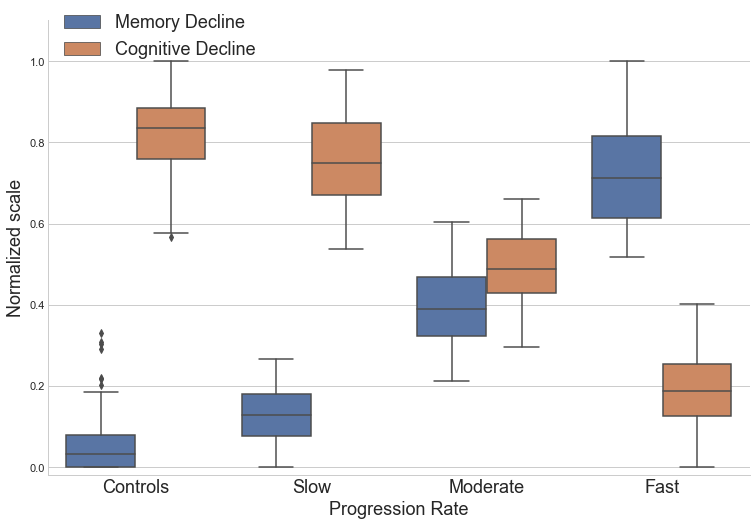

In [32]:

visits = 'm24'
%matplotlib inline
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis, M_H_T2, M_H_T3 = project_data(data, visits)
    
    
M_mci_dem = redued_item_24
M_mci_dem_nmf_all = M_mci_dem[['NMF_2_1','NMF_2_2','NMF_3_1', 'NMF_3_2','NMF_3_3']].copy()
M_mci_dem_nmf = M_mci_dem[['NMF_2_1', 'NMF_2_2']]
M_mci_dem_nmf_proj_all = M_mci_dem_nmf_all[~(redued_item_24.DXCHANGE.isin([1]) )] # removing controls
M_mci_dem_nmf_proj_3d_only = M_mci_dem_nmf_proj_all[['NMF_3_1','NMF_3_2','NMF_3_3']]
M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_all[['NMF_2_1','NMF_2_2']]

try:
    colors_categories_item_24_no_controls = redued_item_24[~(redued_item_24.DXCHANGE.isin([1]) )]['DXCHANGE'].replace([1,2,3], ['red', 'blue', 'green'])
except:
    pass

def organize_prediction_moca(M_mci_dem_nmf_proj_3d_only,Predict_gmm):
    mpl.style.use('seaborn-whitegrid')
    M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_3d_only
    M_mci_dem_nmf_proj['predicted'] = Predict_gmm
    a = list(pd.unique(Predict_gmm.iloc[:,0]))
    srt = np.empty((len(a),2))
    for i in a:
        a = M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #b =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #c =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,0].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        srt[i,1] = a
        srt[i,0] = i
    srt = pd.DataFrame(srt).sort_values([1])
    Predict_gmm.replace([srt.iloc[0,0],srt.iloc[1,0], srt.iloc[2,0] ],[0,1,2], inplace=True)   
    return pd.DataFrame(Predict_gmm)

model_gmm = mixture.GaussianMixture(n_components=3, covariance_type='diag',  random_state = 0)
model_gmm.fit(M_mci_dem_nmf_proj) # print(gmm.means_)
# label the predicted and only keep HC and PDs
Predict_gmm = pd.DataFrame(model_gmm.predict(M_mci_dem_nmf_proj))
print(Predict_gmm.iloc[:,0].value_counts())
Predict_gmm.columns = ['predicted']
Predict_gmm.index = M_mci_dem_nmf_proj.index
Predict_gmm = organize_prediction_moca(M_mci_dem_nmf_proj,Predict_gmm)
M_mci_dem_nmf_proj['predicted'] = Predict_gmm
#plot_side_by_side_2d(M_mci_dem_nmf_proj,Predict_gmm,redued_item_24,colors_categories_item_24,'item24','gmm')    
nl_data = M_mci_dem_nmf[(redued_item_24.DXCHANGE.isin([1]) )]
data_prediction_labels = pd.concat([nl_data,M_mci_dem_nmf_proj]).fillna(3)

cols['apoe4'] = ['RID' , 'VISCODE' , 'APOE4'   ]
apoe4 = pd.read_csv("C:\\Users\\Vipul Satone\\health data\\ADNI\\Raw_Data\\Assessment\\apoe4\\ADNIMERGE.csv",index_col='RID', usecols=cols['apoe4'])
apoe4['VISCODE2'] = apoe4['VISCODE']
apoe4['VISCODE'].value_counts()
del apoe4['VISCODE']
apoe4 = apoe4[apoe4['VISCODE2'].isin(['m24']) ] 
Predict_gmm = data_prediction_labels
redued = Predict_gmm.merge(apoe4['APOE4'].to_frame(), left_index=True, right_index=True)
redued = redued.merge(redued_item_24['DXCHANGE'].to_frame(), left_index=True, right_index=True)

redued['predicted'] = redued['predicted'].replace([0,1,2,3],['Slow','Moderate','Fast','Controls'])
redued['DXCHANGE'] = redued['DXCHANGE'].replace([1,2,3],['Controls','MCI','Dementia'])


redued[['NMF_2_1','NMF_2_2']] = normalize(redued[['NMF_2_1','NMF_2_2']] ,'m')

redued_2 = redued[['NMF_2_1','predicted']]
redued_2['Progression Vector'] = 'Cognitive Decline'
redued_2.columns = ['val','predicted','Progression Vector']
redued_1 = redued[['NMF_2_2','predicted']]
redued_1['Progression Vector'] = 'Memory Decline'
redued_1.columns = ['val','predicted','Progression Vector']
redued_new = pd.concat([redued_1,redued_2])
redued_new['val'] = redued_new['val'].astype(float)

plt.figure(figsize=(15, 10)) 
axis = sns.factorplot("predicted", hue="Progression Vector", y="val", order =  ['Controls', 'Slow','Moderate','Fast'], data=redued_new,size =7, aspect = 1.5, kind="box",legend_out=False)
for ax in axis.axes.flat:
    ax.set_xlabel("Progression Rate",fontsize=18)
    ax.set_ylabel("Normalized scale",fontsize=18)
    ax.set_ylim( ([-0.02,1.1])   )
    ax.legend( fontsize = 18, loc = 'upper-left')
    plt.legend(loc="upper left",  fontsize=18 ,bbox_to_anchor=(0, 1.05) )
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.savefig(address + '\\paper_fig\\' + 'normalized_axis_vs_prog_vectors_24.png',dpi = 200)

## The End